# Assignment 3

Kaylee Molin (22734429)

---

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import random
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, silhouette_score, silhouette_samples
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from pathlib import Path
from graphviz import Source
import matplotlib.patches as patches  # extra code – for the curved arrow
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
import matplotlib.cm as cm

---
---
## Part 1: A model for diagnosing cancer

**Defining the functions to be used in this question.**

---
Task 1 functions:

In [2]:
def plot_pairplot(df, target_col, feature_cols):
    '''Plot a pairplot with modified legend labels'''
    g = sns.pairplot(df, hue=target_col, vars=feature_cols, corner=True)
    g._legend.set_title('Class')
    plt.show()
    return g

In [3]:
def plot_heatmap(corr_matrix, figsize=(20,20)):
    '''plot heatmap using a correaltion matrix'''
    plt.figure(figsize=figsize)
    heatmap = sns.heatmap(corr_matrix, cmap="coolwarm", annot=True)
    print(heatmap)
    plt.show()   

In [4]:
def drop_features(df, feature_list):
    '''Drop features from specified dataframe'''
    return df.drop(feature_list, axis=1)

In [5]:
def split_Xy(data, target_name):
    X = data.iloc[:, :-1]
    y = data[target_name]
    return X, y

In [6]:
def preprocess_data(data, target_name, test_size=0.15):
    '''Split data in the X_train, X_test, y_train, y_test and scale'''
    X, y = split_Xy(data, target_name)

    # Split the data into training and testing sets with 85% for training and 15% for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=123)

    # Scaling the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert X_train and X_test back to a pandas dataframe
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)
    
    return X_train, X_test, y_train, y_test
    

In [7]:
def plot_bar_graph(accuracy_train, accuracy_test, title, xtitle=['Training Set', 'Test Set'], ylabel='Accuracy'):
    '''Plots a bar graph with 2 columns'''
    colors = ['Lightgray', 'Gray']

    plt.bar(xtitle, [accuracy_train, accuracy_test], color=colors)
    plt.title(title)
    plt.ylabel(ylabel)

    for i, v in enumerate([accuracy_train, accuracy_test]):
        plt.text(i, v + 0.01, str(round(v, 4)), color='black', ha='center')

    plt.show()
   

In [8]:
def get_best_clf(clf, param_grid, X_train, y_train, X_test, y_test, model_name):
    # Create the cross-validator object with random_state
    cv = KFold(n_splits=3, random_state=21, shuffle=True)

    # Perform grid search to find the best hyperparameters
    grid_search = GridSearchCV(clf, param_grid, cv=cv)
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters found
    print("Best Hyperparameters:", grid_search.best_params_)

    # Train the decision tree classifier with the best hyperparameters
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    # Evaluate the model on the training set
    accuracy_train = best_model.score(X_train, y_train)
    print("\nAccuracy of the {} model (training): {:.2f}%".format(model_name, accuracy_train * 100))

    # Evaluate the model on the test set
    accuracy_test = best_model.score(X_test, y_test)
    print("Accuracy of the {} model (testing): {:.2f}%".format(model_name, accuracy_test * 100))


    return accuracy_train, accuracy_test, best_model


In [9]:
def plot_side_by_side(x_titles, accuracies_train, accuracies_test, rotate=45, title1='Training Set Accuracies', title2='Testing Set Accuracies', ylabel='Accuracies',ylim=1.05):
    '''Plots 2 bar graphs side-by-side'''
    colors = ['pink', 'lavender', 'lightblue', 'palegreen', 'yellow']
    
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    axes[0].bar(x_titles, accuracies_train, color=colors)
    axes[0].set_title(title1)
    axes[0].set_ylabel(ylabel)
    axes[0].tick_params(axis='x', labelrotation=rotate) # rotate x-tick labels
    axes[0].set_ylim([0, ylim])
    for i, v in enumerate(accuracies_train):
        axes[0].text(i, v + 0.01, str(round(v, 4)), color='black', ha='center')

    # Plot the testing set accuracies
    axes[1].bar(x_titles, accuracies_test, color=colors)
    axes[1].set_title(title2)
    #axes[1].set_ylabel('Accuracy')
    axes[1].tick_params(axis='x', labelrotation=rotate) # rotate x-tick labels
    axes[1].set_ylim([0, ylim])
    for i, v in enumerate(accuracies_test):
        axes[1].text(i, v + 0.01, str(round(v, 4)), color='black', ha='center')

    # Display the plots
    plt.show()

In [10]:
def plot_confusion_matrix(y_test, y_test_pred, label, ax):
    # Calculate the confusion matrix for the test set
    cm_best = confusion_matrix(y_test, y_test_pred)

    # Extract TN, FP, FN, TP values from the confusion matrix
    tn_best, fp_best, fn_best, tp_best = cm_best.ravel()

    # Plot the confusion matrix
    sns.heatmap(cm_best, annot=True, fmt='d', cmap="Purples", annot_kws={"size": 18},
                cbar=False, square=True, xticklabels=['Predicted: M', 'Predicted: B'], 
                yticklabels=['Actual: M', 'Actual: B'], ax=ax)
    ax.text(0.5, 1.1, f"TN={tn_best}\nFP={fp_best}\nFN={fn_best}\nTP={tp_best}", 
    fontsize=12, ha="center", transform=ax.transAxes)
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title(str(label))
    
    return tn_best, fp_best, fn_best, tp_best


In [11]:
def plot_precision_recall(y_test, y_test_pred, label):
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_pred)

    idx = (thresholds >= 0.5).argmax()  # first index ≥ threshold

    plt.plot(recalls, precisions, '--', linewidth=2, label="Precision/Recall curve for "+label)

    # extra code – just beautifies and saves Figure 3–6
    #plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
    #plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
    #plt.plot([recalls[idx]], [precisions[idx]], "ko",
             #label="Point at threshold 0.5")
    plt.gca().add_patch(patches.FancyArrowPatch(
        (0.79, 0.60), (0.61, 0.78),
        connectionstyle="arc3,rad=.2",
        arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
        color="#444444"))
    plt.text(0.56, 0.82, "Higher\nthreshold", color="#333333")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1.01, 0.5, 1.01])
    plt.grid()
    plt.legend(loc="lower left")

    #plt.show()


In [12]:
def plot_with_threshold(y_test, y_pred, title, threshold=0.5):
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)

    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.vlines(threshold, 0, 1.2, "k", "dotted", label="Threshold")

    idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
    plt.axis([0, 1, 0, 1.1])
    plt.grid()
    plt.title(title)
    plt.ylabel("Value")
    plt.xlabel("Threshold")
    plt.legend(loc="center right")

---
Task 2 functions:


In [13]:
def plot_feature_importance(trained_model, data, title, threshold=0.05):
    if hasattr(trained_model, 'feature_importances_'):
        # Decision Tree or Random Forest
        importances = trained_model.feature_importances_
        sorted_idx = importances.argsort()
        plt.barh(range(len(importances)), importances[sorted_idx])
        for i, v in enumerate(importances[sorted_idx]):
            plt.text(v + 0.01, i, str(round(v, 3)))
        plt.yticks(range(len(importances)), data.columns[sorted_idx])
        plt.xlabel('Feature Importance')
    elif hasattr(trained_model, 'coef_'):
        # Logistic Regression
        coefficients = np.abs(trained_model.coef_[0])
        coef_sum = np.sum(coefficients)
        coefficients = coefficients/coef_sum
        sorted_idx = np.abs(coefficients).argsort()
        plt.barh(range(len(coefficients)), coefficients[sorted_idx])
        for i, v in enumerate(coefficients[sorted_idx]):
            plt.text(v + 0.01, i, str(round(v, 3)))
        plt.yticks(range(len(coefficients)), data.columns[sorted_idx])
        plt.xlabel('Absolute Coefficient')
    else:
        raise ValueError('The model does not support feature importances or coefficients.')
    
    plt.title(title)
    plt.show()


---
Task 3 functions:


In [14]:
def pca_plot(X_pca, pca, y):

    # Calculate the variance ratio explained by the first two principal components
    variance_ratio = pca.explained_variance_ratio_

    cmap = ListedColormap(['hotpink', 'cornflowerblue'])

    # Create a scatter plot of the data on the first two principal components
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=cmap, alpha=0.5)
    plt.xlabel('1st Principal Component')
    plt.ylabel('2nd Principal Component')
    plt.title('PCA Scatter Plot of Breast Cancer Dataset')

    # force the ticks
    cb = plt.colorbar(ticks=[0.25,.75])
    cb.set_ticklabels([0,1])
    cb.ax.set_yticklabels(['0 - Benign', '1 - Malignant'])
    plt.show()

    print(f"Proportion of data variance explained by the first two principal components: {sum(variance_ratio):.2f}")


In [15]:
def pca_plot_biplot(X_pca, feature_names, y, pca):

    cmap = ListedColormap(['hotpink', 'cornflowerblue'])
    
    # Create a biplot with variable vectors
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=cmap, alpha=0.5)

    # Plot variable vectors with loadings and longer lines
    feature_vectors = pca.components_.T * np.sqrt(pca.explained_variance_)
    for i, feature in enumerate(feature_names):
        loadings_text = f'{feature} ({feature_vectors[i, 0]:.2f}, {feature_vectors[i, 1]:.2f})'
        ax.arrow(0, 0, feature_vectors[i, 0]*4, feature_vectors[i, 1]*4, color='black', alpha=0.7, linewidth=2)
        ax.text(feature_vectors[i, 0] * 4.2, feature_vectors[i, 1] * 4.2, loadings_text, color='black', fontweight='bold')

    ax.set_xlabel('1st Principal Component')
    ax.set_ylabel('2nd Principal Component')
    ax.set_title('Biplot of Data on the First Two Principal Components')

    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)

    cbar = plt.colorbar(scatter, ax=ax, ticks=[0.25, 0.75])
    cbar.set_ticklabels([0, 1])
    cbar.ax.set_yticklabels(['0 - Benign', '1 - Malignant'])

    plt.show()


---
Task 5 functions:


In [16]:
def get_num_comps(X, variance_limit=0.95):
    n_components=X.shape[1]
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    explained_variance_ratio = pca.explained_variance_ratio_

    # Calculate the cumulative explained variance ratio
    explained_variance_ratio_cumulative = np.cumsum(explained_variance_ratio)

    # Find the number of components to retain 95% of the explained variance
    num_components = np.argmax(explained_variance_ratio_cumulative >= variance_limit) + 1

    # Print the explained variance ratio of each component
    for i, ratio in enumerate(explained_variance_ratio):
        print(f"Component {i+1}: Explained Variance Ratio = {ratio:.4f}")

    # Print the components contributing to 95% of the explained variance
    print(f"\nComponents contributing to at least {variance_limit*100:.0f}% of the explained variance: {num_components}")
    print(f"\nVariance retained using {num_components} components: {100*explained_variance_ratio_cumulative[num_components-1]:.2f}%")
    return num_components

---

## Part  - Task 1

**Building a logistic regression and a decision tree model to predict the status of a tumour**

In [17]:
# Importing the data
cancer_data = pd.read_csv("breast-cancer.csv")

# Viewing the data to look at the features
cancer_data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


> The "id" column is unnecessary in the model and will be removed. The "diagnosis" column will be set as the target. The 'M' and the 'B' labels will be replaced with 1 and 0 respectively.

In [18]:
# Removing the "id" column
cancer_data = drop_features(cancer_data, "id")

# Setting 'M' -> 1 and 'B' -> 0
cancer_data['diagnosis'] = cancer_data['diagnosis'].replace({'M': 1, 'B': 0})

**Viewing correlations between features (not to be removed)**

Axes(0.125,0.11;0.62x0.77)


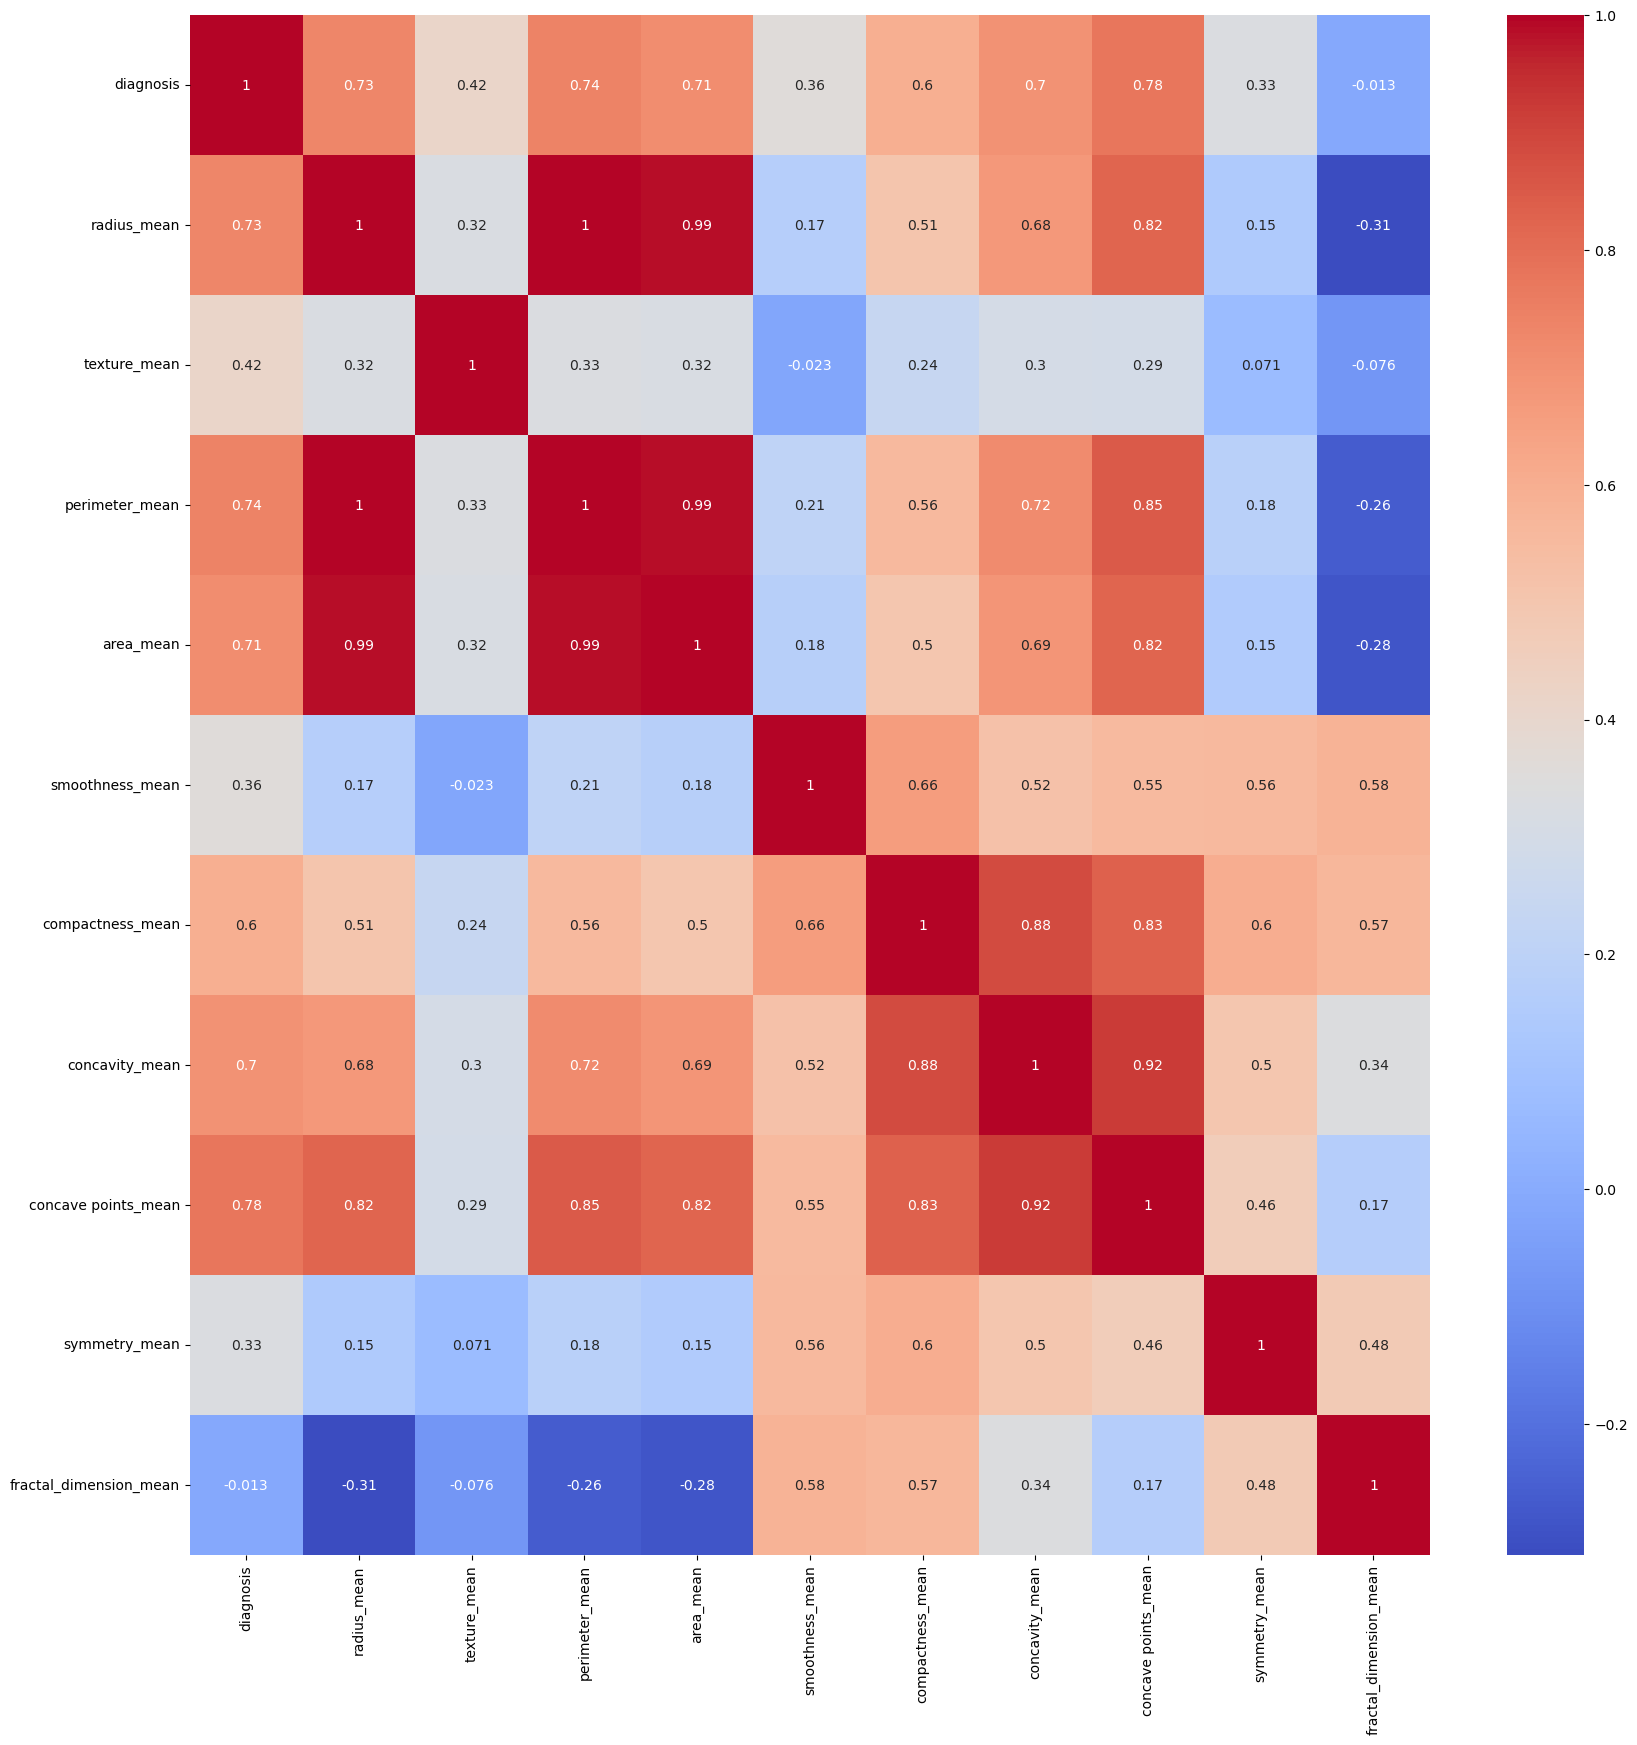

In [19]:
corr_matrix_cancer = cancer_data.corr()

plot_heatmap(corr_matrix_cancer)

> There are many highly correlated features. Redundant features can introduce unnecessary complexity to the model and potentially lead to overfitting. These features will not be removed at this stage as PCA will identify them anyway. However, removing features can help with:

>1. Multicollinearity: Highly correlated features often exhibit multicollinearity, which means they provide similar information to the model. When multicollinearity is present, it becomes difficult for the model to discern the individual contribution of each feature, potentially leading to unstable and unreliable results.

>2. Simplifying the model: By removing redundant features, you simplify the model and reduce its complexity. It becomes easier to understand the impact of each remaining feature on the model's predictions and reduces computational time.

>3. Better generalisation: Removing redundant features can help prevent overfitting. By reducing the number of correlated features, the model focuses on the essential information, allowing it to generalise better and make more accurate predictions on unseen data.

**Determining the size of the dataset and if it is balanced or not**

In [20]:
cancer_data.shape

(569, 11)

> The Wisconsin Breast Cancer dataset contains a total of 569 samples, which is relatively small in terms of sample size. When building a model for predicting cancer diagnosis, it is crucial to have both high accuracy and high sensitivity. Given the limited size of this dataset, it may pose challenges in achieving the necessary model performance. 

**Checking if the dataset is balanced**

In [21]:
# Count number of instances for each class label
diagnosis_counts = cancer_data['diagnosis'].value_counts()
print(diagnosis_counts)

0    357
1    212
Name: diagnosis, dtype: int64


> This dataset is imbalanced, with 357 benign (0) diagnoses and 212 malignant (1) diagnoses. The dataset is skewed towards the benign class. Imbalanced datasets can affect the model's ability to accurately predict the minority class (in this case, malignant samples). Since the number of malignant samples is relatively smaller, the model may tend to favour predicting the majority class (benign) more frequently. This needs to be considered when assessing the model's performance.

**Scaling the data and preprocessing it**

In [22]:
cancer_data= cancer_data.reindex(columns=[col for col in cancer_data.columns if col != 'diagnosis'] + ['diagnosis'])
X_train, X_test, y_train, y_test = preprocess_data(cancer_data, 'diagnosis', test_size=0.2)

> The dataset contains only 569 samples. Therefore, a 20% test size is chosen because it allows for a reasonable evaluation while still preserving a sufficient number of samples for training purposes.

### Building a logistic regression model

**Using Grid search and cross validation (implemented within `get_best_clf`) to find the best hyperparameters for the model**

In [23]:
logreg = LogisticRegression()

param_grid_lr = {
    'C': [100, 10, 1.0, 0.1, 0.01],
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'solver': ['liblinear', 'saga'], 
    'max_iter': [10000]
}

accuracy_train_lr, accuracy_test_lr, best_lr = get_best_clf(logreg, param_grid_lr, X_train, y_train, X_test, y_test, 'logistic regression')

Best Hyperparameters: {'C': 0.1, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga'}

Accuracy of the logistic regression model (training): 93.63%
Accuracy of the logistic regression model (testing): 95.61%


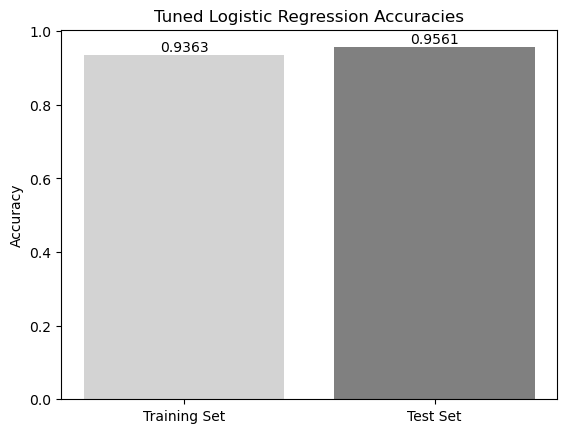

In [ ]:
plot_bar_graph(accuracy_train_lr, accuracy_test_lr, 'Tuned Logistic Regression Accuracies')

The parameters `C`, `penalty`, `class_weight` and `solver` were used in this grid search to explore a range of possible values and combinations that could potentially optimise the performance of the model.

* The `C` parameter represents the inverse of regularisation strength. Higher values of `C` correspond to less regularisation, allowing the model to potentially fit the training data more closely.
* The `penalty` parameter determines the type of regularisation used (L1 or L2 which correspond with Lasso and Ridge regression respectively).
* The `class_weight` parameter is used with `balanced` and `None` options to handle class imbalance in the dataset. This dataset is imbalanced, hence may be necessary to use this parameter. It allows the model to assign different weights to different classes during training to more fairly represent the classes leading to more accurate predictions.
* The `solver` parameter offers different algorithms to solve the optimisation problem. `liblinear` and `saga` are selected.

> As seen in the above accuracy plot, the Logistic Regression model performs very well on both the testing and training sets, with accuracies above 93% for both. This may suggest that the Logistic Regression model is well suited for this problem. However, it is important to assess the model in a variety of ways before making conclusion on its suitability.

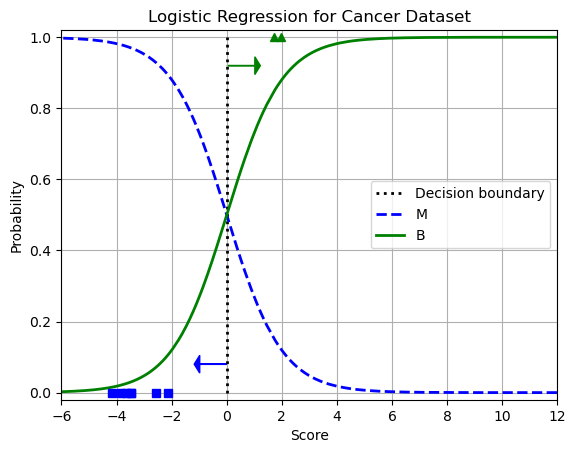

Decision boundary for the logistic regression model: 0.01987


In [24]:
# Extract the terms from the trained logistic regression model
weights = best_lr.coef_
bias = best_lr.intercept_

# Compute the dot product of input data with the transposed weights and add the bias term
dots = np.dot(X_train, np.transpose(weights)) + bias

# Predict the class probabilities using the logistic regression model
y_axis = best_lr.predict_proba(X_train)

# Sort the dot product values and corresponding class probabilities
dots_sorted, y_sorted = zip(*sorted(zip(dots, y_axis)))

# Extract the decision boundary
decision_boundary = np.array(dots_sorted)[np.array(y_sorted)[:, 1] >= 0.5][0, 0]

plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2, label="Decision boundary")
plt.title("Logistic Regression for Cancer Dataset")
plt.plot(dots_sorted, np.array(y_sorted)[:, 0], "b--", linewidth=2, label="M")
plt.plot(dots_sorted, np.array(y_sorted)[:, 1], "g-", linewidth=2, label="B") 

plt.arrow(x=decision_boundary, y=0.08, dx=-1, dy=0, head_width=0.05, head_length=0.2, fc="b", ec="b")
plt.arrow(x=decision_boundary, y=0.92, dx=1, dy=0, head_width=0.05, head_length=0.2, fc="g", ec="g")
plt.legend(loc="center right")

# Retrieving 10 random instances to plot from the testing set
random.seed(21)
random_indices = np.sort(np.array([random.randint(0, len(X_test)) for _ in range(10)]))

dots_testing = (np.dot(X_test, np.transpose(weights)) + bias)[random_indices]
y_axis_testing = (best_lr.predict_proba(X_test))[random_indices]
y_axis_proba = (best_lr.predict(X_test))[random_indices]
plt.xlabel("Score")
plt.ylabel("Probability")
plt.grid()

s=y_axis_testing[:,0]
d=y_axis_testing[:,1]
plt.axis([-6, 12, -0.02, 1.02]) # [x left lim, x right lim, y lower lim, y upper lim]

plt.plot(dots_testing[y_axis_proba == 0], y_axis_proba[y_axis_proba == 0], "bs")
plt.plot(dots_testing[y_axis_proba == 1], y_axis_proba[y_axis_proba == 1], "g^")

plt.legend()
plt.show()

print(f"Decision boundary for the logistic regression model: {decision_boundary:.5f}")

> The decision boundary is very close to 0 which can be advantageous. This is because the dataset aims to classify tumours as either malignant or benign based on various features. A decision boundary near 0 indicates that the model is making predictions based on a subtle balance between the two classes, potentially leading to more accurate and precise classifications.

### Building a decision tree

In [25]:
dtree = DecisionTreeClassifier()

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

accuracy_train_dt, accuracy_test_dt, best_dt = get_best_clf(dtree, param_grid_dt, X_train, y_train, X_test, y_test, 'decision tree')

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}

Accuracy of the decision tree model (training): 97.80%
Accuracy of the decision tree model (testing): 88.60%


In [26]:
IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        pltbefig(path, format=fig_extension, dpi=resolution)

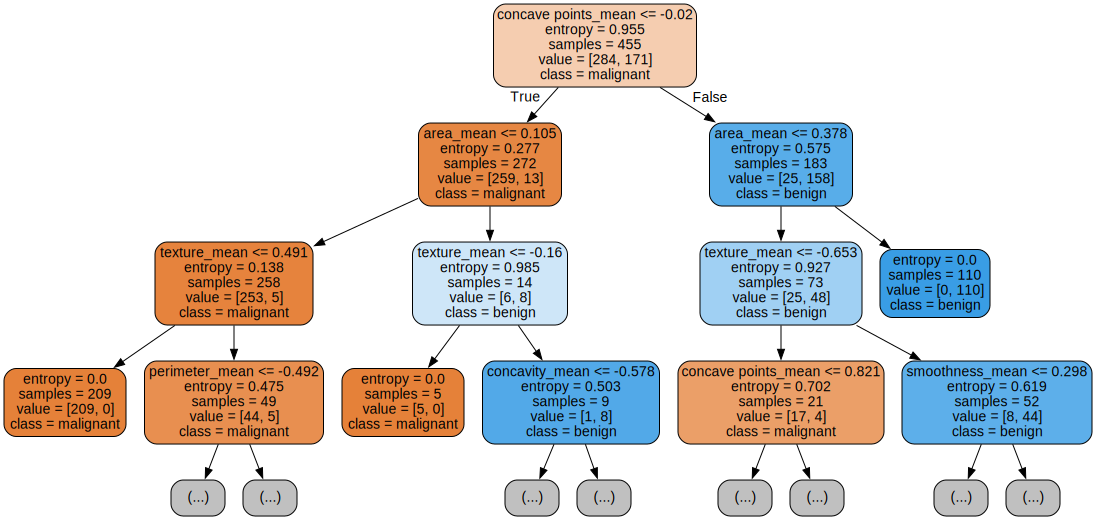

In [27]:
export_graphviz(
        best_dt,
        out_file=str(IMAGES_PATH / "tree.dot"), 
        feature_names=list(X_train.columns),
        class_names=['malignant', 'benign'],
        rounded=True,
        filled=True,
    	max_depth=3
    )

Source.from_file(IMAGES_PATH / "tree.dot")


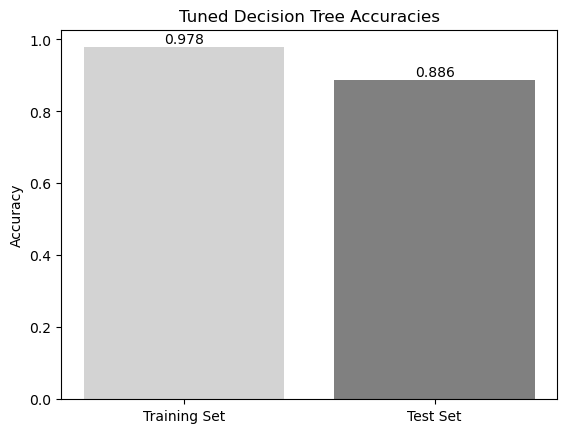

In [28]:
plot_bar_graph(accuracy_train_dt, accuracy_test_dt, 'Tuned Decision Tree Accuracies')

The parameters `criterion`, `max_depth`, `min_samples_split` and `min_samples_leaf` were used in this grid search to explore a range of possible values and combinations that could potentially optimise the performance of the model.

* The `criterion`: [`gini`, `entropy`]: The criterion parameter determines the quality of a split in the decision tree. By including both `gini` and `entropy`, we assess two commonly used metrics for measuring impurity, enabling us to compare their performance and select the better criterion.

- `max_depth`: [None, 5, 10, 15]: The max_depth parameter defines the maximum depth of the decision tree. This allows us to avoid overfitting or underfitting and find an appropriate depth that balances complexity and performance.

- `min_samples_split`: [2, 5, 10]: The min_samples_split parameter sets the minimum number of samples required to split an internal node.

- `min_samples_leaf`: [1, 2, 4]: The min_samples_leaf parameter specifies the minimum number of samples required to be at a leaf node. 

> The accuracy of the decision tree model on the training set was very high at aroung 98%, indicating a strong ability to fit the training data. On the testing set, the model achieved an accuracy of around 90%. It is possible that this model is overfitting to the training data as seen by the high trainig set accuracy and lower testing set accuracy. Also, looking at the decision tree, some nodes have an entropy of 0 indicating a perfect separation of the data, which could suggest potential overfitting.

### Comparing the Logisitc Regression Model with the Decision Tree Classifier

**Comparison of Accuracies**

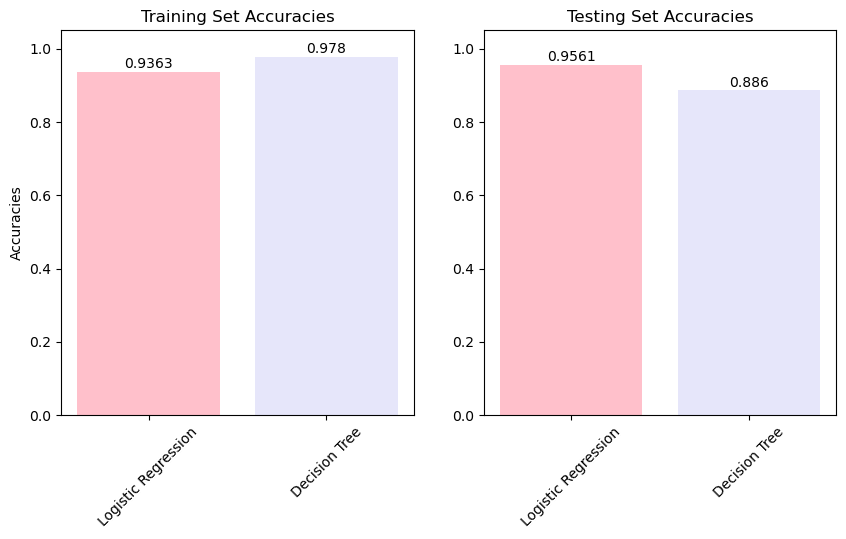

In [29]:
plot_side_by_side(['Logistic Regression', 'Decision Tree'], [accuracy_train_lr, accuracy_train_dt], [accuracy_test_lr, accuracy_test_dt])

**Comparison of Confusion Matrices**

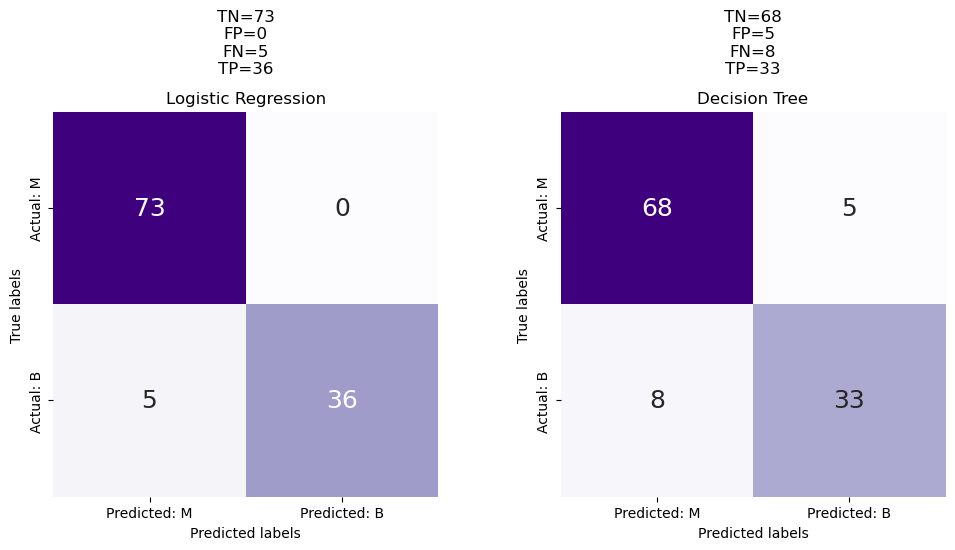

In [30]:
y_pred_lr = best_lr.predict(X_test)
y_pred_dt = best_dt.predict(X_test)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Modified line: 1 row, 2 columns

tn_best_default, fp_best_default, fn_best_default, tp_best_default = plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression", axs[0])
tn_best_depth, fp_best_depth, fn_best_depth, tp_best_depth = plot_confusion_matrix(y_test, y_pred_dt, "Decision Tree", axs[1])

#plt.tight_layout()
plt.show()

**Comparison Precision/Recall Curves**

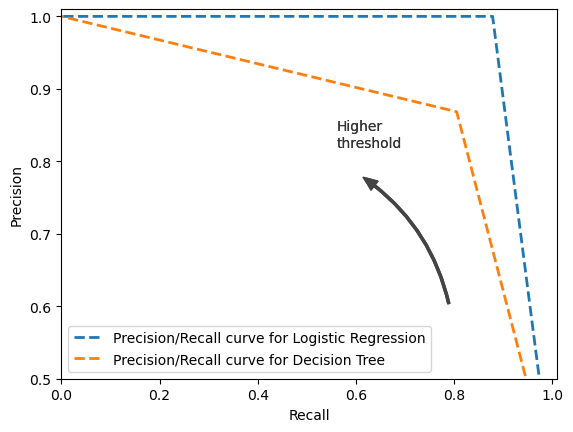

In [31]:
plot_precision_recall(y_test, y_pred_lr, "Logistic Regression")
plot_precision_recall(y_test, y_pred_dt, "Decision Tree")

plt.show()

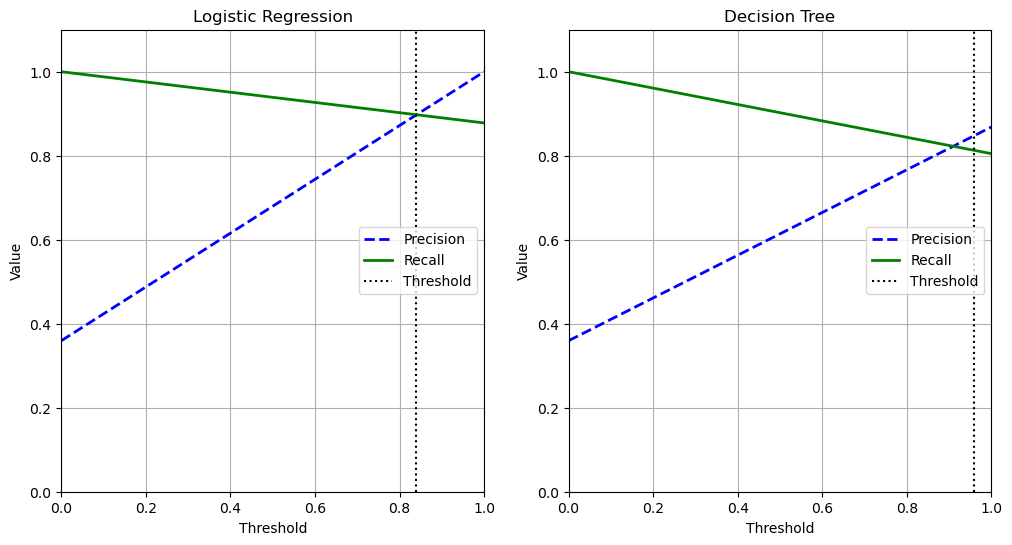

In [32]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first subplot
plt.sca(axes[0])
plot_with_threshold(y_test, y_pred_lr, "Logistic Regression", threshold=0.84)

# Plot the second subplot
plt.sca(axes[1])
plot_with_threshold(y_test, y_pred_dt, "Decision Tree", threshold=0.96)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Show the figure
plt.show()


> The objective of the model is to precisely classify tumours as either benign (B) or malignant (M) by utilizing information from the Breast Cancer Wisconsin Diagnostic Dataset. The dataset's features provide details about cell nuclei extracted from suspicious breast tissue through a fine needle. The primary purpose is to use these features to effectively identify breast cancer. The ultimate aim is to develop a dependable and precise model that can assist in the early detection and treatment of breast cancer.

> Based on the accuracy of both the training and testing datasets, logistic regression achieved higher accuracy compared to the decision tree. Logistic regression achieved an accuracy of 0.9561 on the testing dataset, while the decision tree achieved an accuracy of around 0.9. Considering the nature of a clinical setting where accurate predictions are crucial, logistic regression's higher accuracy suggests that it may be more appropriate for this particular scenario.

> When dealing with classification of this nature, it is very important to correctly identify all positive cases as positives. Therefore, a model with a high true positive (TP) rate and a low false negative (FN) rate is desired, even if that comes at the cost of a greater number of false positives. This is not too much of an issue, as the patient will simply undergo further tests to confirm or deny the positive (malignant) diagnosis. A measure of TP and FN is called sensitivity.

> The precision-recall curve also shows a higher precision for logistic regression. This indicates that logistic regression may have a better ability to correctly identify positive cases (higher precision) compared to the decision tree.

> Considering all these factors, it is recommended to use logistic regression in this clinical setting due to its higher accuracy, higher precision and higher sensitivity. However, specific clinical requirements and computational power should be considered when making a final selection.

---
## Part 1 - Task 2

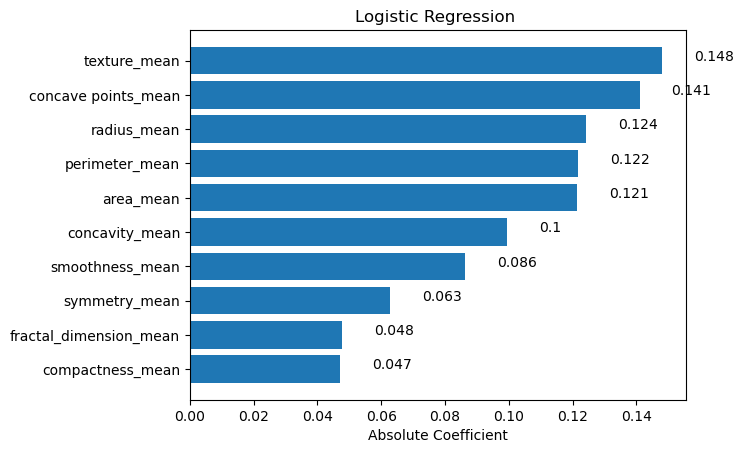

In [33]:
plot_feature_importance(best_lr, cancer_data, "Logistic Regression ")

**Feature importance for the Decision Tree model**

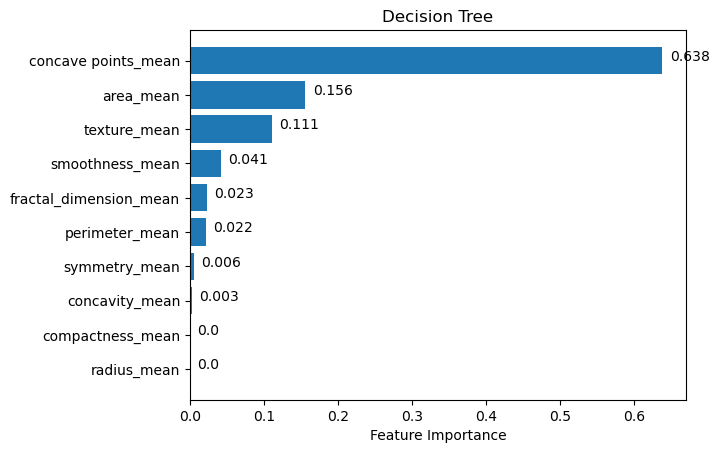

In [34]:
plot_feature_importance(best_dt,cancer_data, "Decision Tree")

**Discussion about feature importances**

> Both models exhibit relatively similar levels of feature importance. Both models identify `concave_points_mean` as a highly important feature. On the other hand, `compactness_mean` and `symmetry_mean` are considered less significant in both models.

> However, an interesting observation is the varying importance attributed to `radius_mean` between the two models. `radius_mean` displays a strong correlation with `area_mean` as seen in the correlation matrix in Task 1. The decision tree model seems to incorporate `area_mean` into its model, which potentially explains the relatively lower importance assigned to `radius_mean` due to redundancy.

> This fairly high level of consistency in feature importance is reassuring, as it suggests that these particular features consistently hold valuable information for tumour status prediction. Therefore, they should be given significant consideration when interpreting the models and making decisions based on their outputs.

---
## Part 1 - Task 3

**Creating a scatter plot of the data using the first 2 principle components using PCA**

In [35]:
# No longer using testing and training set in PCA
X = cancer_data.iloc[:, 0:-1]
y = cancer_data.iloc[:, -1]

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

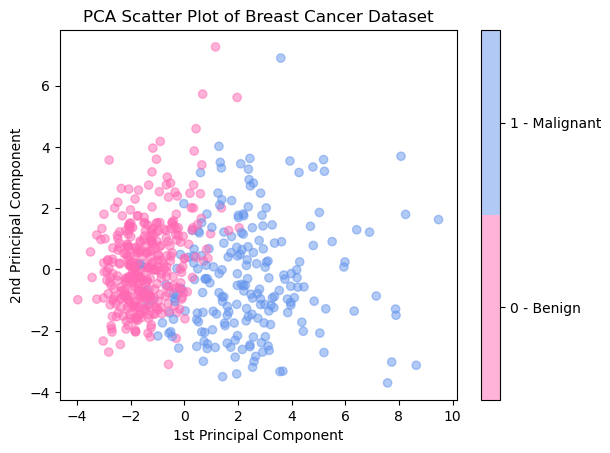

Proportion of data variance explained by the first two principal components: 0.80


In [36]:
# Defining the PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plotting the PCA
pca_plot(X_pca, pca, y)

> The first and second principle components make up 80% of the variance in the data.

---
## Part 1 - Task 4 & 5

**Creating a biplot with the variables vectors and the observed data projected on the first two principal components**

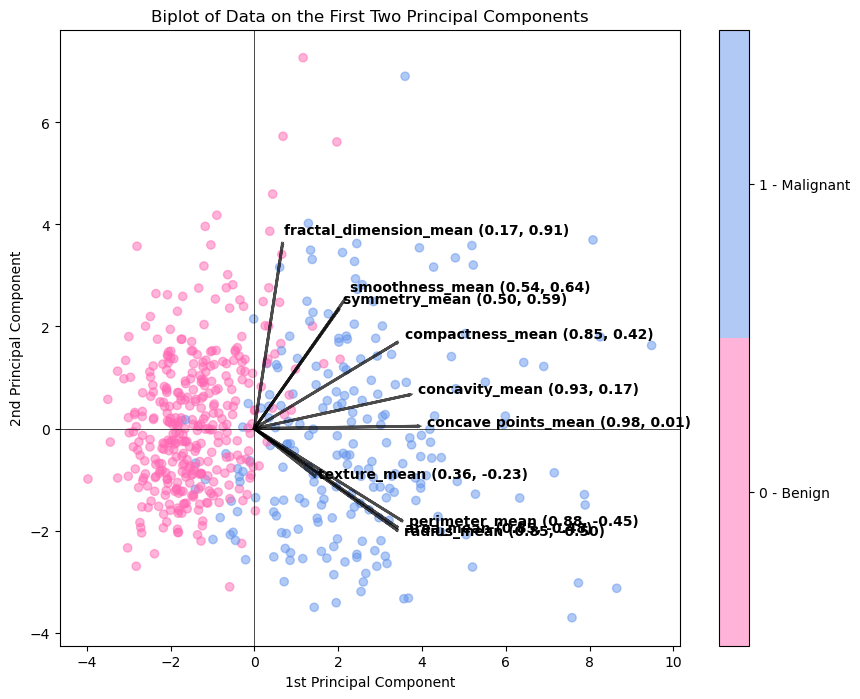

In [37]:
feature_names = cancer_data.columns[0:-1]

pca_plot_biplot(X_pca, feature_names, y, pca)

> The PCA plot of the dataset with loadings reveals important features about the data. Firstly, there is a clear separation between the benign and malignant samples, with many benign samples clustering on the negative side of the 1st principal component, while numerous malignant instances are concentrated on the positive end. A decision boundary can be placed between the two classes. The 1st principle component holds most of the variance of the data, hence, is more important to the categorisation of the data,

> In the lower right of this plot, there is a collection of overlapping features, `perimeter_mean`, `area_mean`, and `radius_mean`. These features are highly correlated due to the circular nature of the cell's nucleus. The PCA plot confirms this correlation, as they exhibit similar loadings. The `texture_mean` feature also aligns with the same direction, but with a lower loading, indicating its relatively lower importance. The direction of these four features suggests a fairly strong correlation between them and the classification of instances, as they are pointing away from the decision boundary. Also, a significant proportion of their direction lies within the 1st principal component, which accounts for a larger portion of the variance compared to the y-direction (2nd principal axis).

> `concave_points_mean`, `concavity_mean`, and `compactness_mean` show the largest component in the direction of the 1st principal component. This indicates their higher importance in categorising the instances.

> In the direction of the decision boundary, we observe features such as `fractal_dimension_mean`, `smoothness_mean`, and `symmetry_mean`. These features have larger components in the y-direction, indicating their lesser importance compared to the previously discussed features. Moreover, since they align with the decision boundary direction, they do not provide significant valuable information for the classification.

> Comparing the "important" features we discussed (`concave_points_mean`, `concavity_mean`, and `compactness_mean`), the fairly important features (`perimeter_mean`, `area_mean`, `radius_mean`, and `texture_mean`), and the "unimportant features" (`fractal_dimension_mean`, `smoothness_mean`, and `symmetry_mean`) with the feature importances observed in Task 2, we notice many similarities. The general order of features remains consistent. This indicates that PCA is effective in providing valuable information about features in a dataset.

---
## Part 1 - Task 6

**Determining the number of features to retain 95% variance**

In [38]:
num_components = get_num_comps(X_scaled)

Component 1: Explained Variance Ratio = 0.5479
Component 2: Explained Variance Ratio = 0.2519
Component 3: Explained Variance Ratio = 0.0881
Component 4: Explained Variance Ratio = 0.0499
Component 5: Explained Variance Ratio = 0.0373
Component 6: Explained Variance Ratio = 0.0124
Component 7: Explained Variance Ratio = 0.0080
Component 8: Explained Variance Ratio = 0.0035
Component 9: Explained Variance Ratio = 0.0011
Component 10: Explained Variance Ratio = 0.0000

Components contributing to at least 95% of the explained variance: 5

Variance retained using 5 components: 97.49%


**Now using 5 features for PCA and repeating task 1**

In [39]:
# Retain the desired number of components
pca5 = PCA(n_components=num_components)

X_train_PCA = pca5.fit_transform(X_train)
X_test_PCA = pca5.transform(X_test)

log_reg_PCA = LogisticRegression()

log_reg_PCA.fit(X_train_PCA, y_train)
y_pred_test_PCA = log_reg_PCA.predict(X_test_PCA)
y_pred_train_PCA = log_reg_PCA.predict(X_train_PCA)

param_grid_lr = {
    'C': [100, 10, 1.0, 0.1, 0.01],
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'solver': ['liblinear', 'saga'], 
    'max_iter': [10000]
}

accuracy_train_lr_PCA, accuracy_test_lr_PCA, best_lr_PCA = get_best_clf(log_reg_PCA, param_grid_lr, X_train_PCA, y_train, X_test_PCA, y_test, model_name='logistic regression')

Best Hyperparameters: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}

Accuracy of the logistic regression model (training): 93.63%
Accuracy of the logistic regression model (testing): 96.49%


**Dimension of new dataset**

In [40]:
# Get the shape of the projected dataset
num_samples, num_features = X_train_PCA.shape

# Print the dimension of the projected dataset
print("Dimension of the projected traing dataset: {} x {}".format(num_samples, num_features))

Dimension of the projected traing dataset: 455 x 5


> Now, just 5 features are used instead of 10. This makes the model much more computationally efficient.

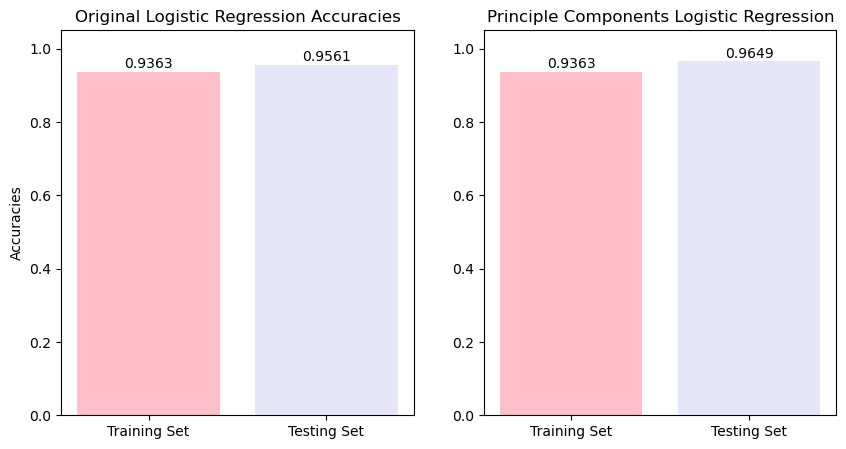

In [41]:
plot_side_by_side(['Training Set', 'Testing Set'], [accuracy_train_lr, accuracy_test_lr], [accuracy_train_lr_PCA, accuracy_test_lr_PCA], rotate=0, title1='Original Logistic Regression Accuracies', title2='Principle Components Logistic Regression', ylabel='Accuracies',ylim=1.05)

> We observe a similar accuracy for both the training and testing sets when using only the top 5 PCA components. This indicates that despite reducing the number of features, the model is still able to capture a significant amount of information necessary for accurate predictions. It is likely that noise in the original dataset was filtered out when using PCA, resulting in the similar accuracies, despite using less information. It also may be generalising better with less data.

> By using the top 5 PCA components, we achieve a good balance between feature reduction and preserving the essential characteristics of the data. This reduction in dimensionality can be advantageous in terms of computational efficiency and mitigating the risk of overfitting.



---
---
## Part 2 - A Clustering Analysis on Airlines Safety Records

**Defining the functions to be used in this question.**

In [42]:
def plot_silhouette(X):
    # Define a list to store the silhouette scores
    silhouette_scores = []
    # Perform K-means clustering for values of K ranging from 2 to 8
    for k in range(2, 9):
        # Create a K-means instance
        kmeans = KMeans(n_clusters=k, random_state=5508, n_init=10)
        kmeans.fit(X)
        labels = kmeans.predict(X)
        silhouette_avg = silhouette_score(X, labels)
        silhouette_scores.append(silhouette_avg)

    # Plot the silhouette scores
    plt.plot(range(2, 9), silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for K-means Clustering')
    plt.show()


In [43]:
def plot_silhouette_and_elbow(X_data):
    # Define a list to store the silhouette scores and SSE
    silhouette_scores = []
    sse = []
    
    # Perform K-means clustering for values of K ranging from 2 to 8
    for k in range(2, 9):
        # Create a K-means instance
        kmeans = KMeans(n_clusters=k, random_state=5508, n_init=10)
        kmeans.fit(X_data)
        labels = kmeans.predict(X_data)
        
        # Calculate silhouette score and append to the list
        silhouette_avg = silhouette_score(X_data, labels)
        silhouette_scores.append(silhouette_avg)
        
        # Calculate SSE and append to the list
        sse.append(kmeans.inertia_)
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot silhouette scores on the left subplot
    ax1.plot(range(2, 9), silhouette_scores, marker='o')
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Silhouette Score')
    ax1.set_title('Silhouette Score for K-means Clustering')
    
    # Plot SSE on the right subplot
    ax2.plot(range(2, 9), sse, marker='o')
    ax2.set_xlabel('Number of Clusters (K)')
    ax2.set_ylabel('Sum of Squared Distances')
    ax2.set_title('Elbow Analysis for K-means Clustering')
    
    # Adjust spacing between subplots
    plt.tight_layout()
    
    # Show the plot
    plt.show()


In [44]:
def plot_elbow(X):
    # Define a list to store the sum of squared distances (SSE)
    sse = []
    
    # Perform K-means clustering for values of K ranging from 1 to 10
    for k in range(2, 9):
        # Create a K-means instance
        kmeans = KMeans(n_clusters=k, random_state=5508, n_init=10)
        kmeans.fit(X)
        
        # Append the sum of squared distances to the list
        sse.append(kmeans.inertia_)
    
    # Plot the SSE values
    plt.plot(range(2, 9), sse, marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Sum of Squared Distances')
    plt.title('Elbow Analysis for K-means Clustering')
    plt.show()


In [50]:
def plot_knife(X_data):
    X_data = pd.DataFrame(X_data)
    
    fig, axes = plt.subplots(4, 2, figsize=(18, 28))
    plt.subplots_adjust(hspace=0.3, top=0.95)

    for n_clusters, ax1 in zip(range(2, 9), axes.flatten()):
        # The 1st subplot is the silhouette plot
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X_data) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        clusterer = KMeans(n_clusters=n_clusters, n_init=10, random_state=5508)
        cluster_labels = clusterer.fit_predict(X_data)

        # Compute the silhouette scores for each sample
        silhouette_avg = silhouette_score(X_data, cluster_labels)
        #print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

        sample_silhouette_values = silhouette_samples(X_data, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10

        ax1.set_title(f"The silhouette plot for n_clusters = {n_clusters}")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])
        ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # Display silhouette score
        ax1.text(0.5, 0.95, f"Silhouette Score: {silhouette_avg:.3f}", transform=ax1.transAxes, ha="center", va="top")

    # Remove the final empty plot
    fig.delaxes(axes[3, 1])

    plt.suptitle("Silhouette analysis for KMeans clustering on airline safety data", fontsize=14, fontweight="bold")
    plt.show()


In [46]:
def display_cluster_lists(Z, data, thresh):
    # Assign cluster labels based on the chosen cutoff
    clusters = fcluster(Z, t=thresh, criterion='distance')

    # Create a dictionary to store the states in each cluster
    cluster_states = {}

    # Iterate over the unique cluster labels
    for cluster_label in set(clusters):
        # Filter the dataset based on the current cluster label
        states = data.loc[clusters == cluster_label, 'State'].tolist()
        
        # Store the list of states in the cluster dictionary
        cluster_states[cluster_label] = states

    # Print the states in each cluster
    for cluster_label, states in cluster_states.items():
        print(f"Cluster {cluster_label}: {states}")


In [47]:
def plot_sns(original_data, vars, labels, title='Pairplot for Features Showing KMeans Clusters'):
    colours = sns.color_palette('Set2', n_colors=3)

    # Set a larger font size
    sns.set(font_scale=1.2, style="white")

    # Create a copy of the data with the cluster labels
    data_with_clusters = original_data.copy()
    data_with_clusters['Cluster'] = labels

    # Plot pairplot
    g = sns.pairplot(data_with_clusters, vars=vars.columns, hue='Cluster', palette=colours)
    
    # Set the title
    g.fig.suptitle(title, y=1.03)

    # Show the plot
    plt.show()


---
## Part 2 - Task 1

### Unscaled Data

**Silhouette scores and Elbow for K-mean clustering at varying Ks**

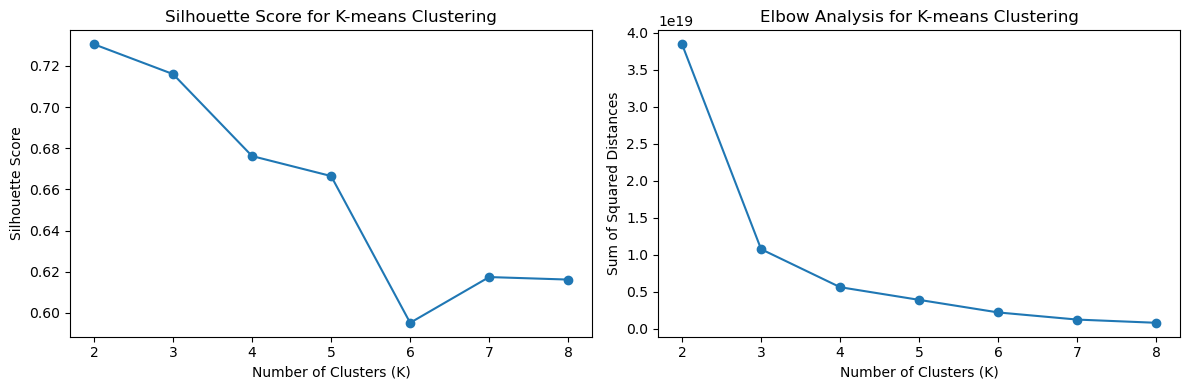

In [48]:
# Load the dataset
airline_data = pd.read_csv('airline-safety.csv')

# Extract the relevant columns for clustering
X = airline_data.iloc[:, 1:]
plot_silhouette_and_elbow(X)

**Silhouette analysis for the unscaled data**

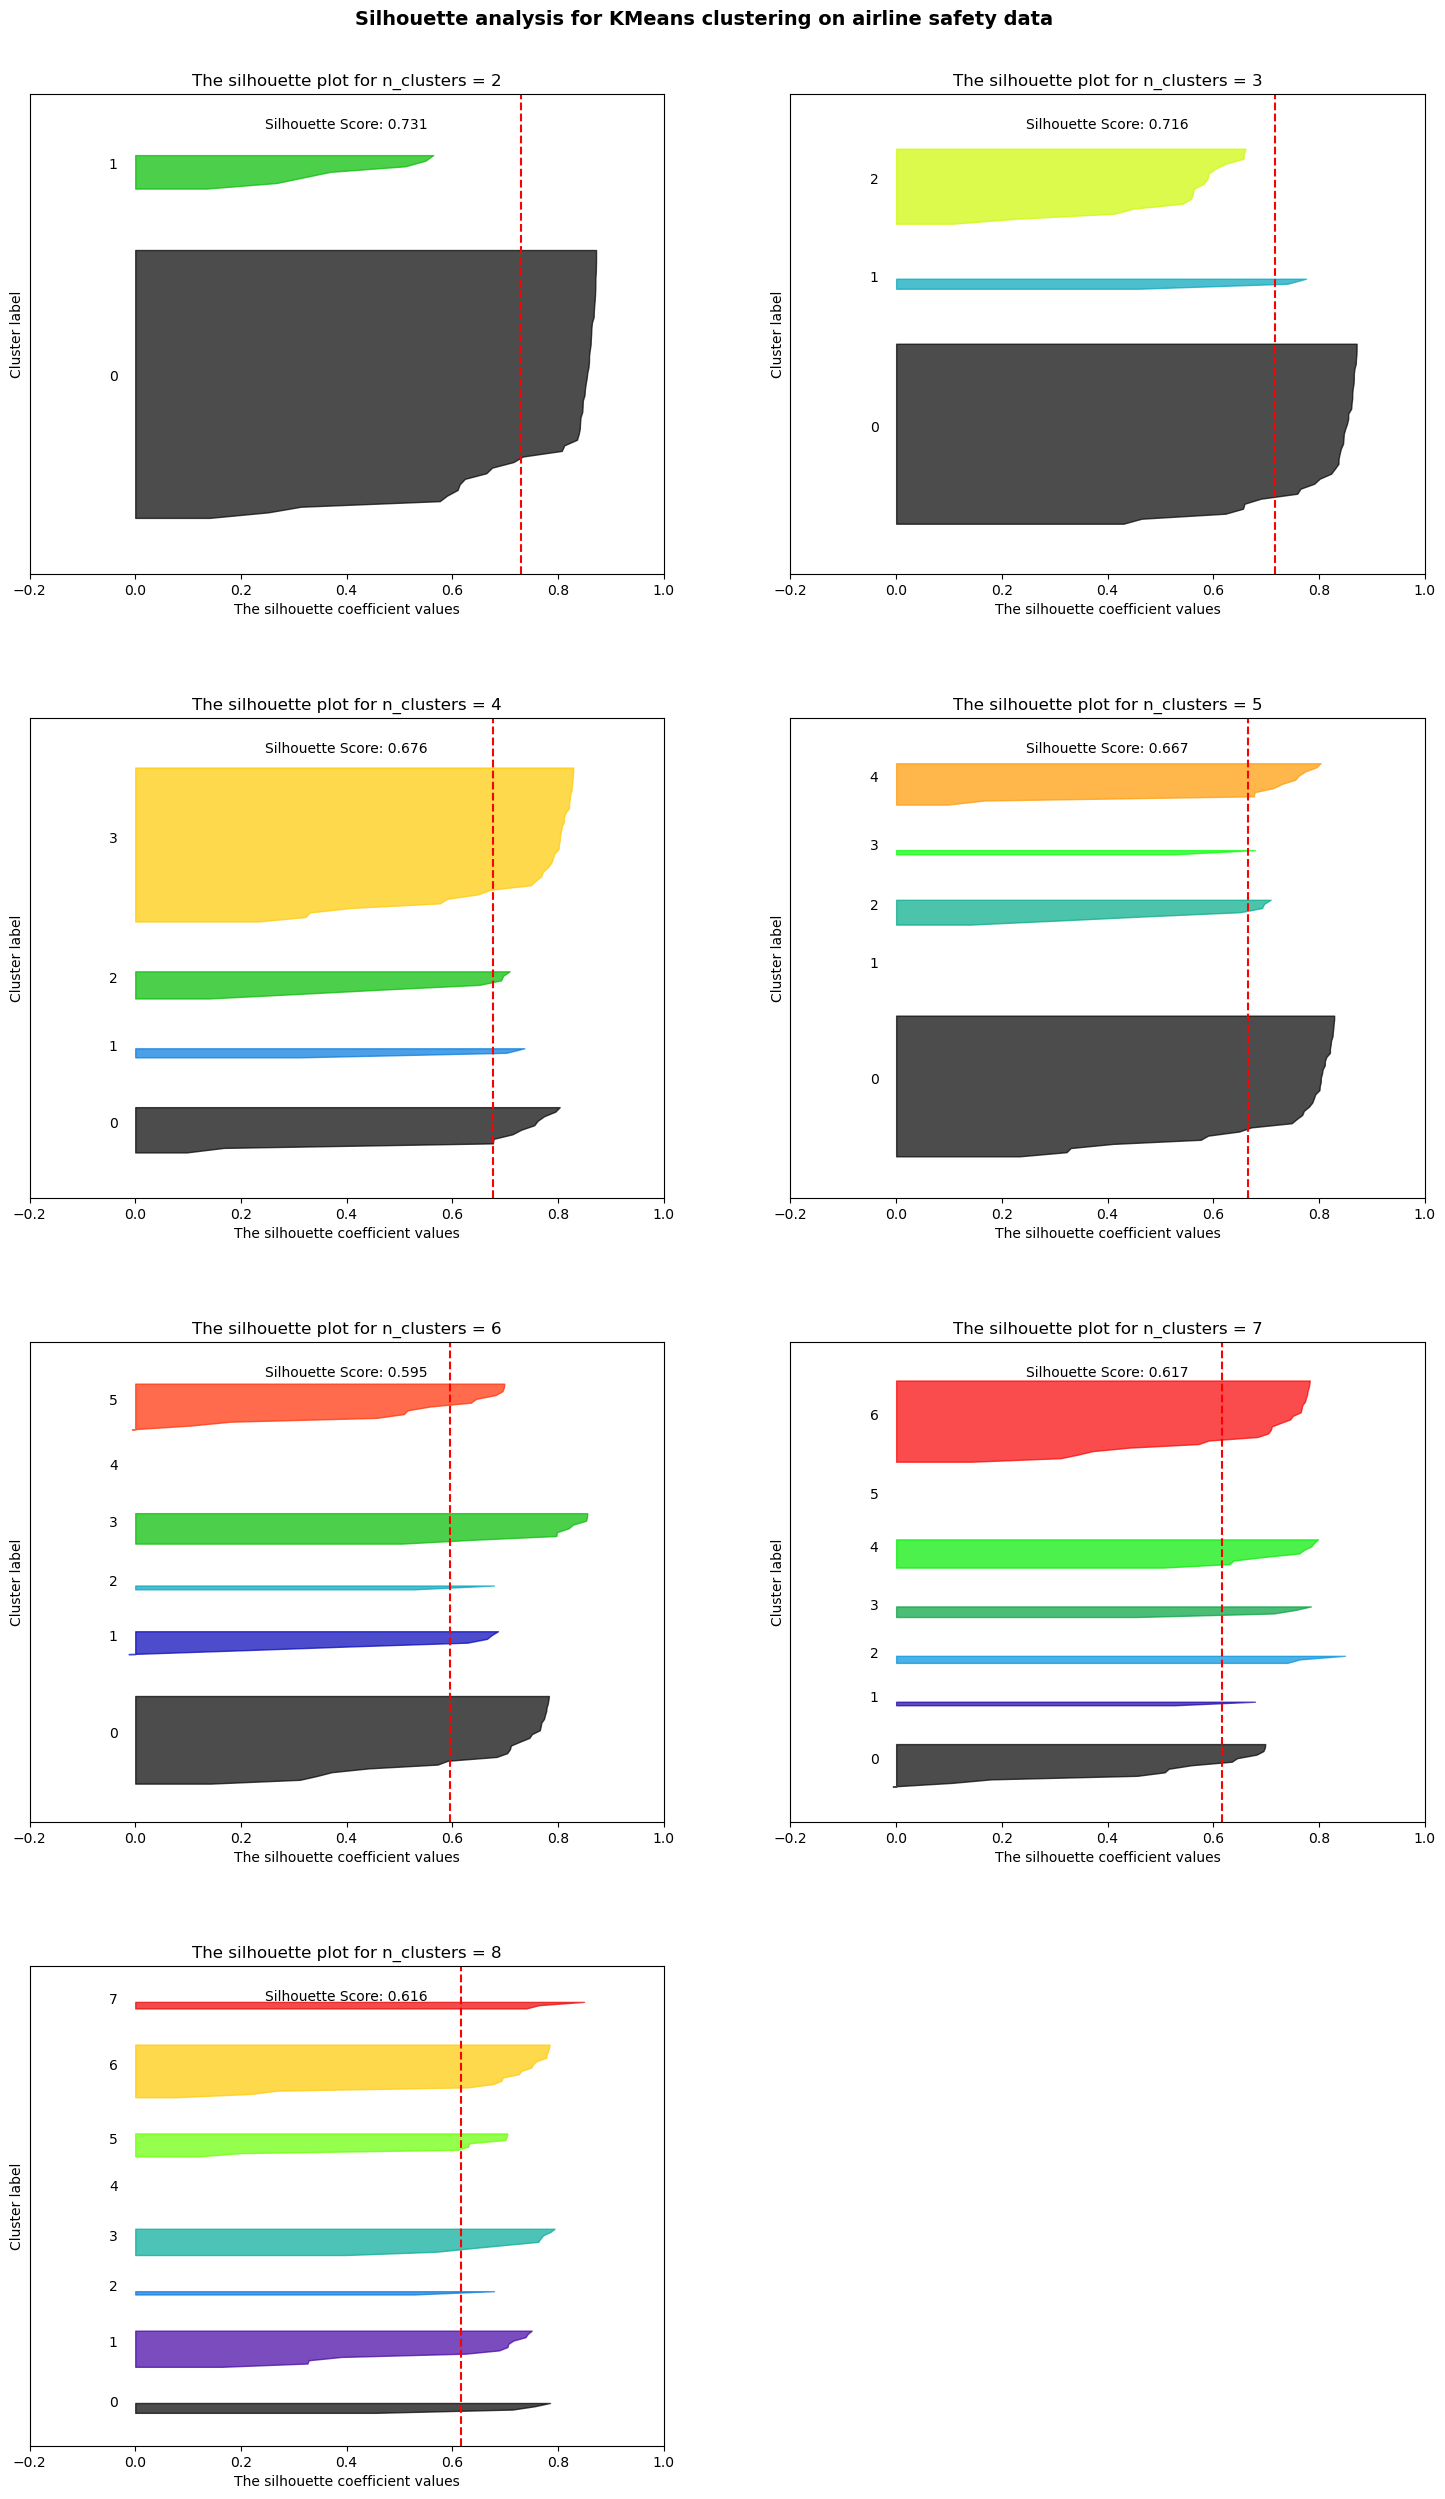

In [51]:
plot_knife(X)

> Although the unscaled data results in high scores for various values of k, it does not provide accurate and representative information. This is because the `avail_seat_km_per_week` parameter is several orders of magnitude larger than the other parameters. Therefore, we will not use this data for further analysis.

### Scaled data

**Silhouette score and Elbow for K-mean clustering at varying Ks for the scaled data**

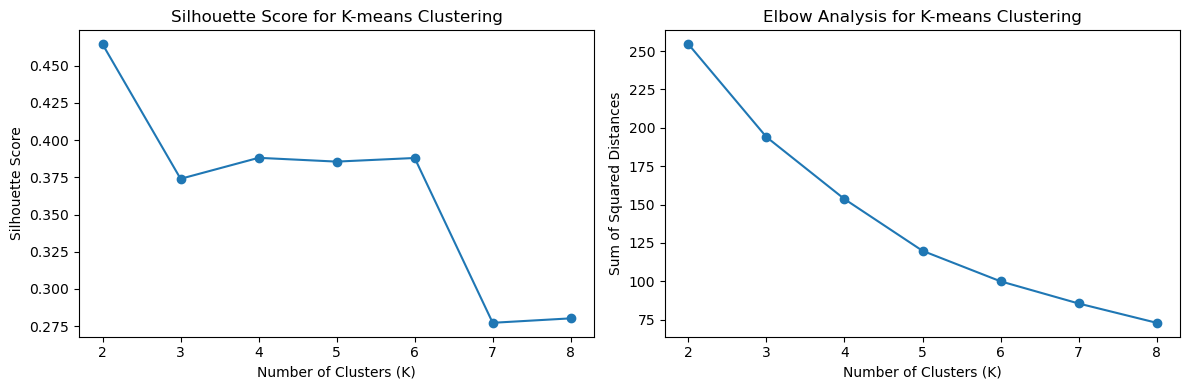

In [52]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
plot_silhouette_and_elbow(X_scaled)

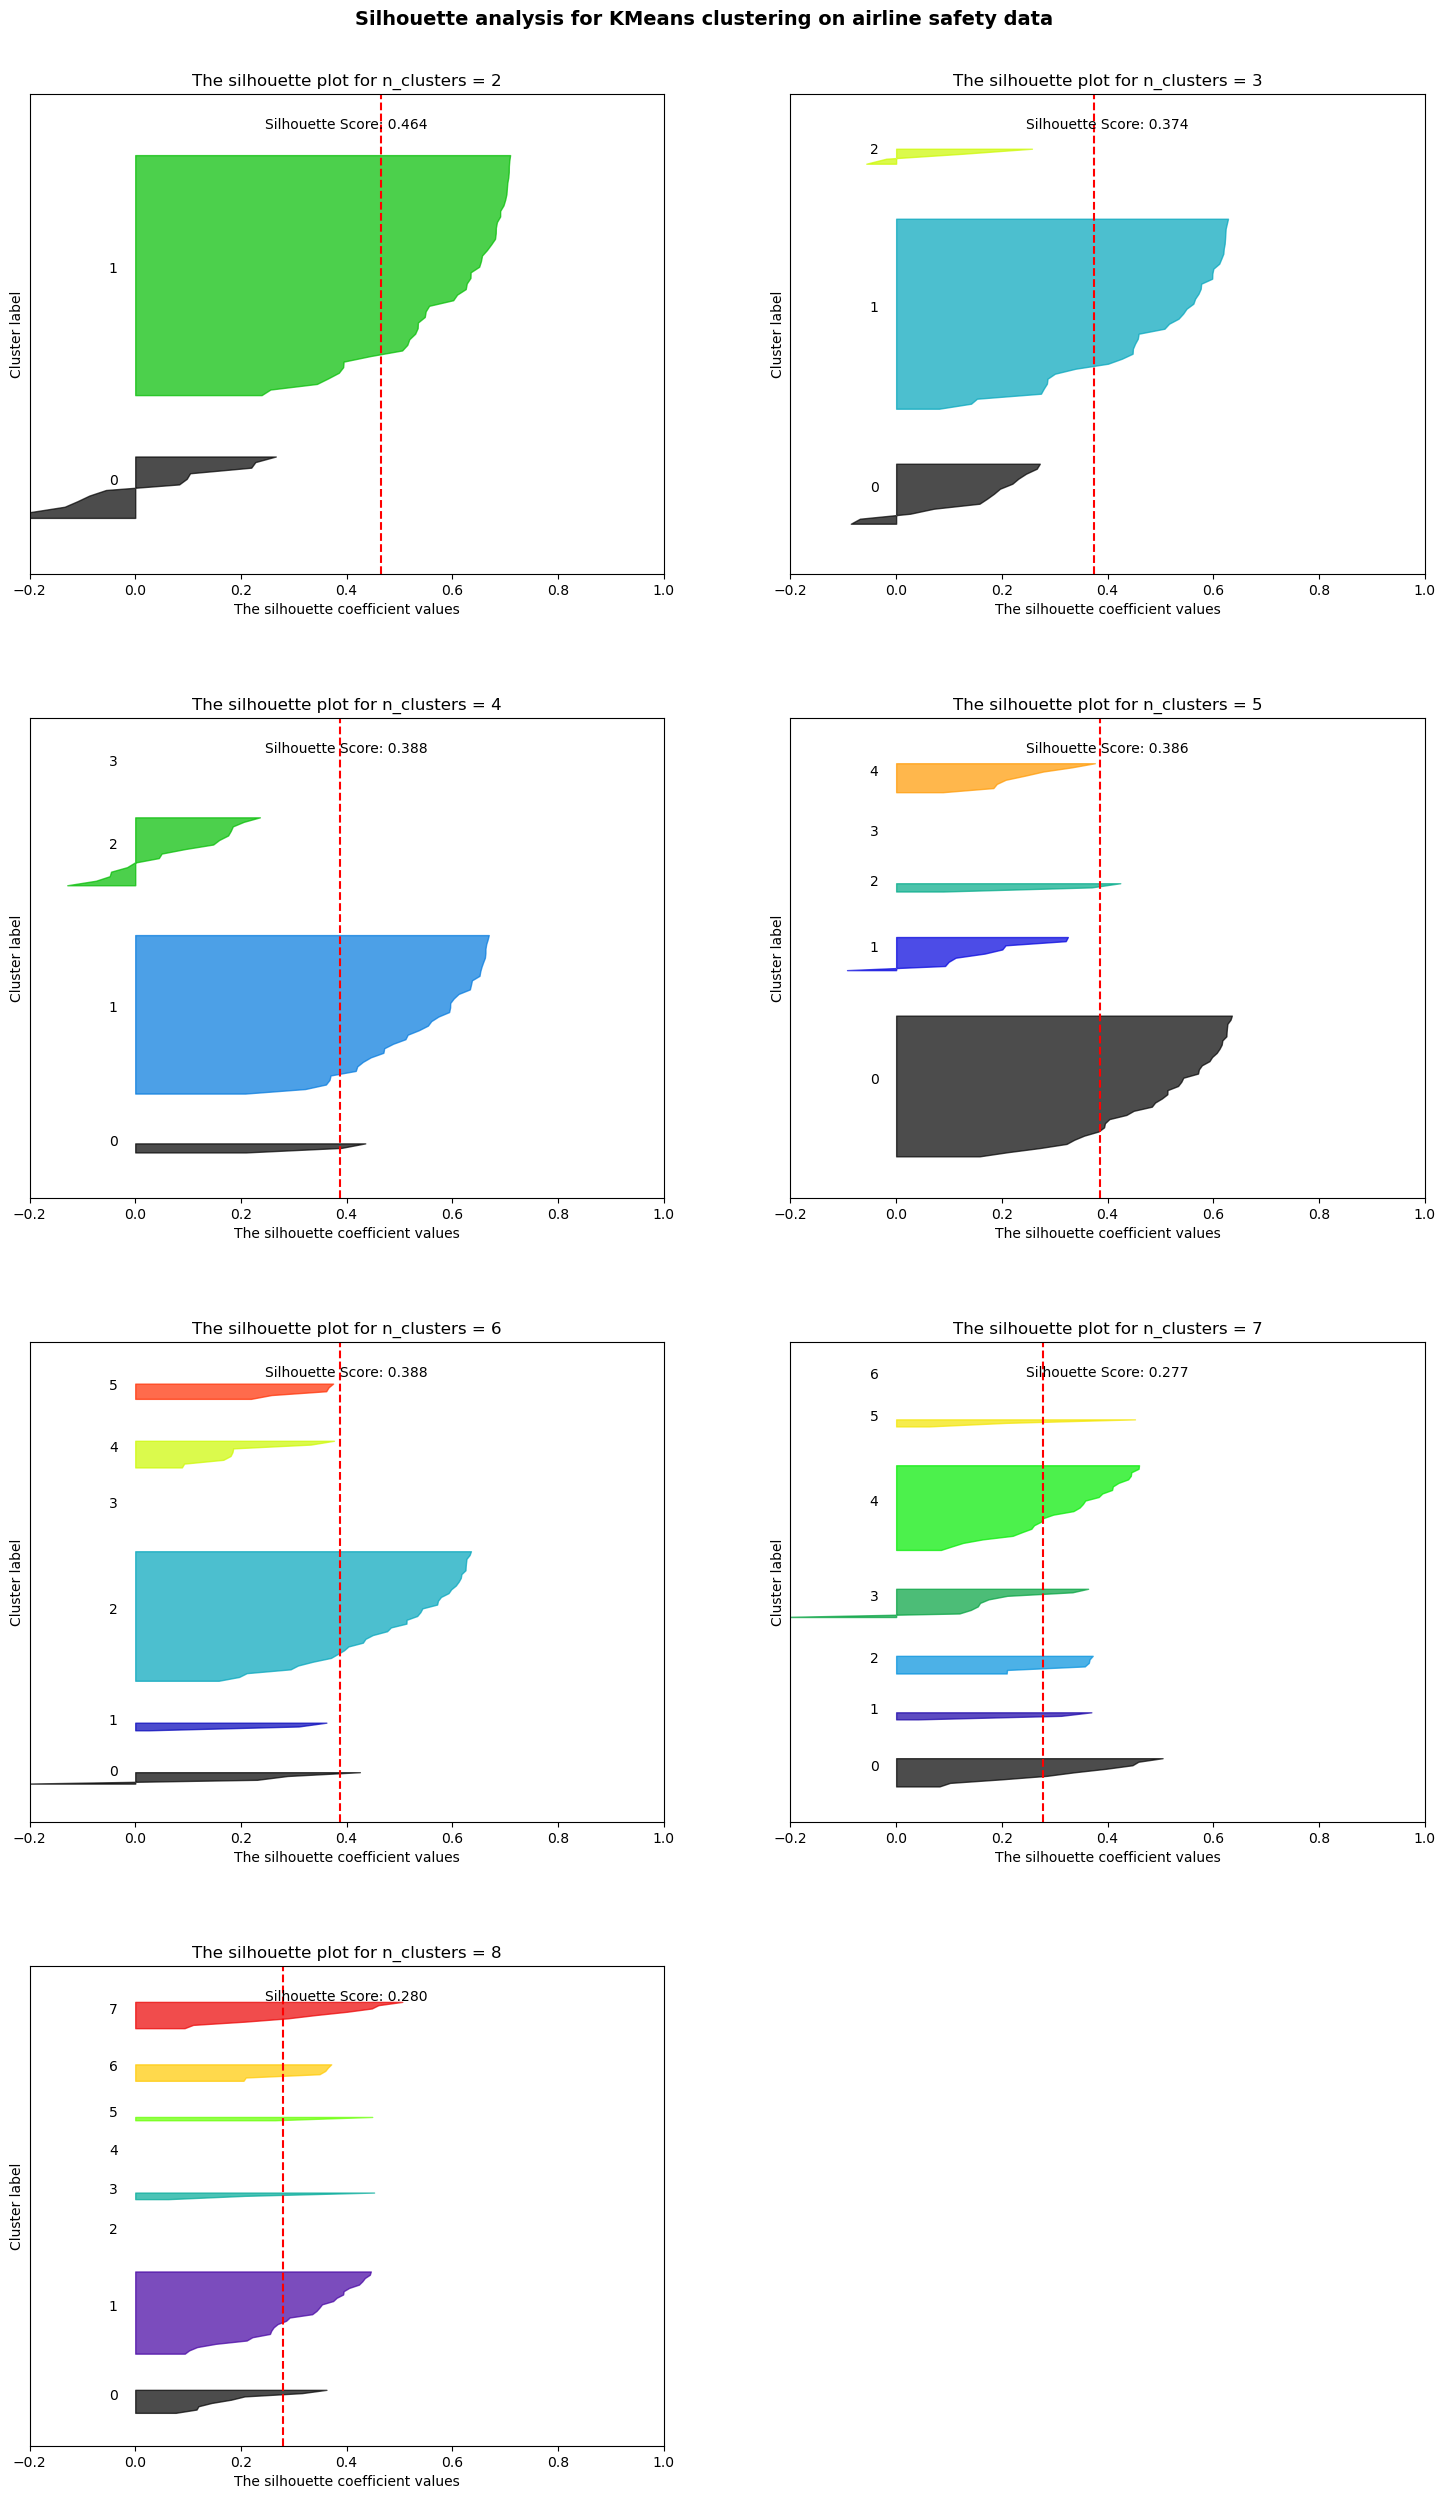

In [53]:
plot_knife(X_scaled)

> The scaled data addresses the issue of varying feature magnitudes. However, the silhouette scores for the scaled data are low, with many instances incorrectly assigned to clusters, as indicated by negative scores in the silhouette analysis. Therefore, using the scaled data is also not a suitable choice in this scenario.

### Unscaled data and removing `avail_seat_km_per_week`
**Silhouette score and Elbow for K-mean clustering at varying Ks for the uscaled data and dropping the `avail_seat_km_per_week` feature**

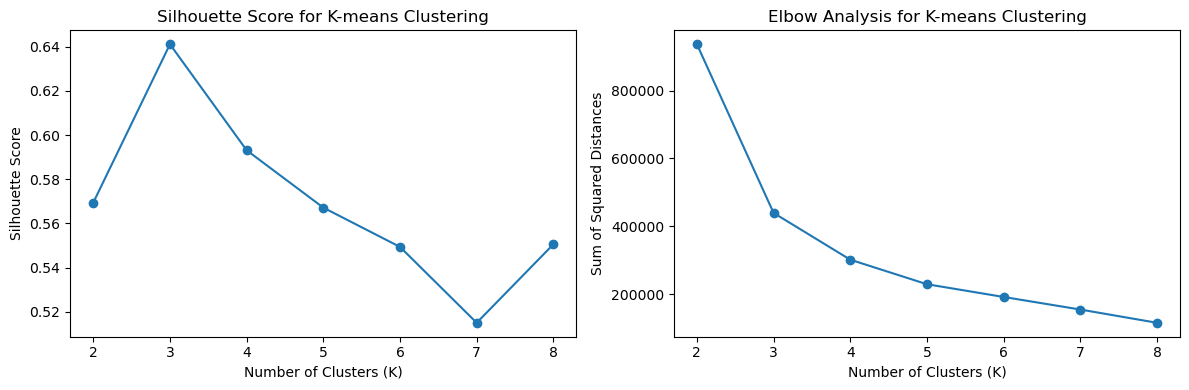

In [54]:
airline_data_dropped = airline_data.drop('avail_seat_km_per_week', axis=1)
# Extract the relevant columns for clustering
X_drop_km = airline_data_dropped.iloc[:, 1:]
plot_silhouette_and_elbow(X_drop_km)

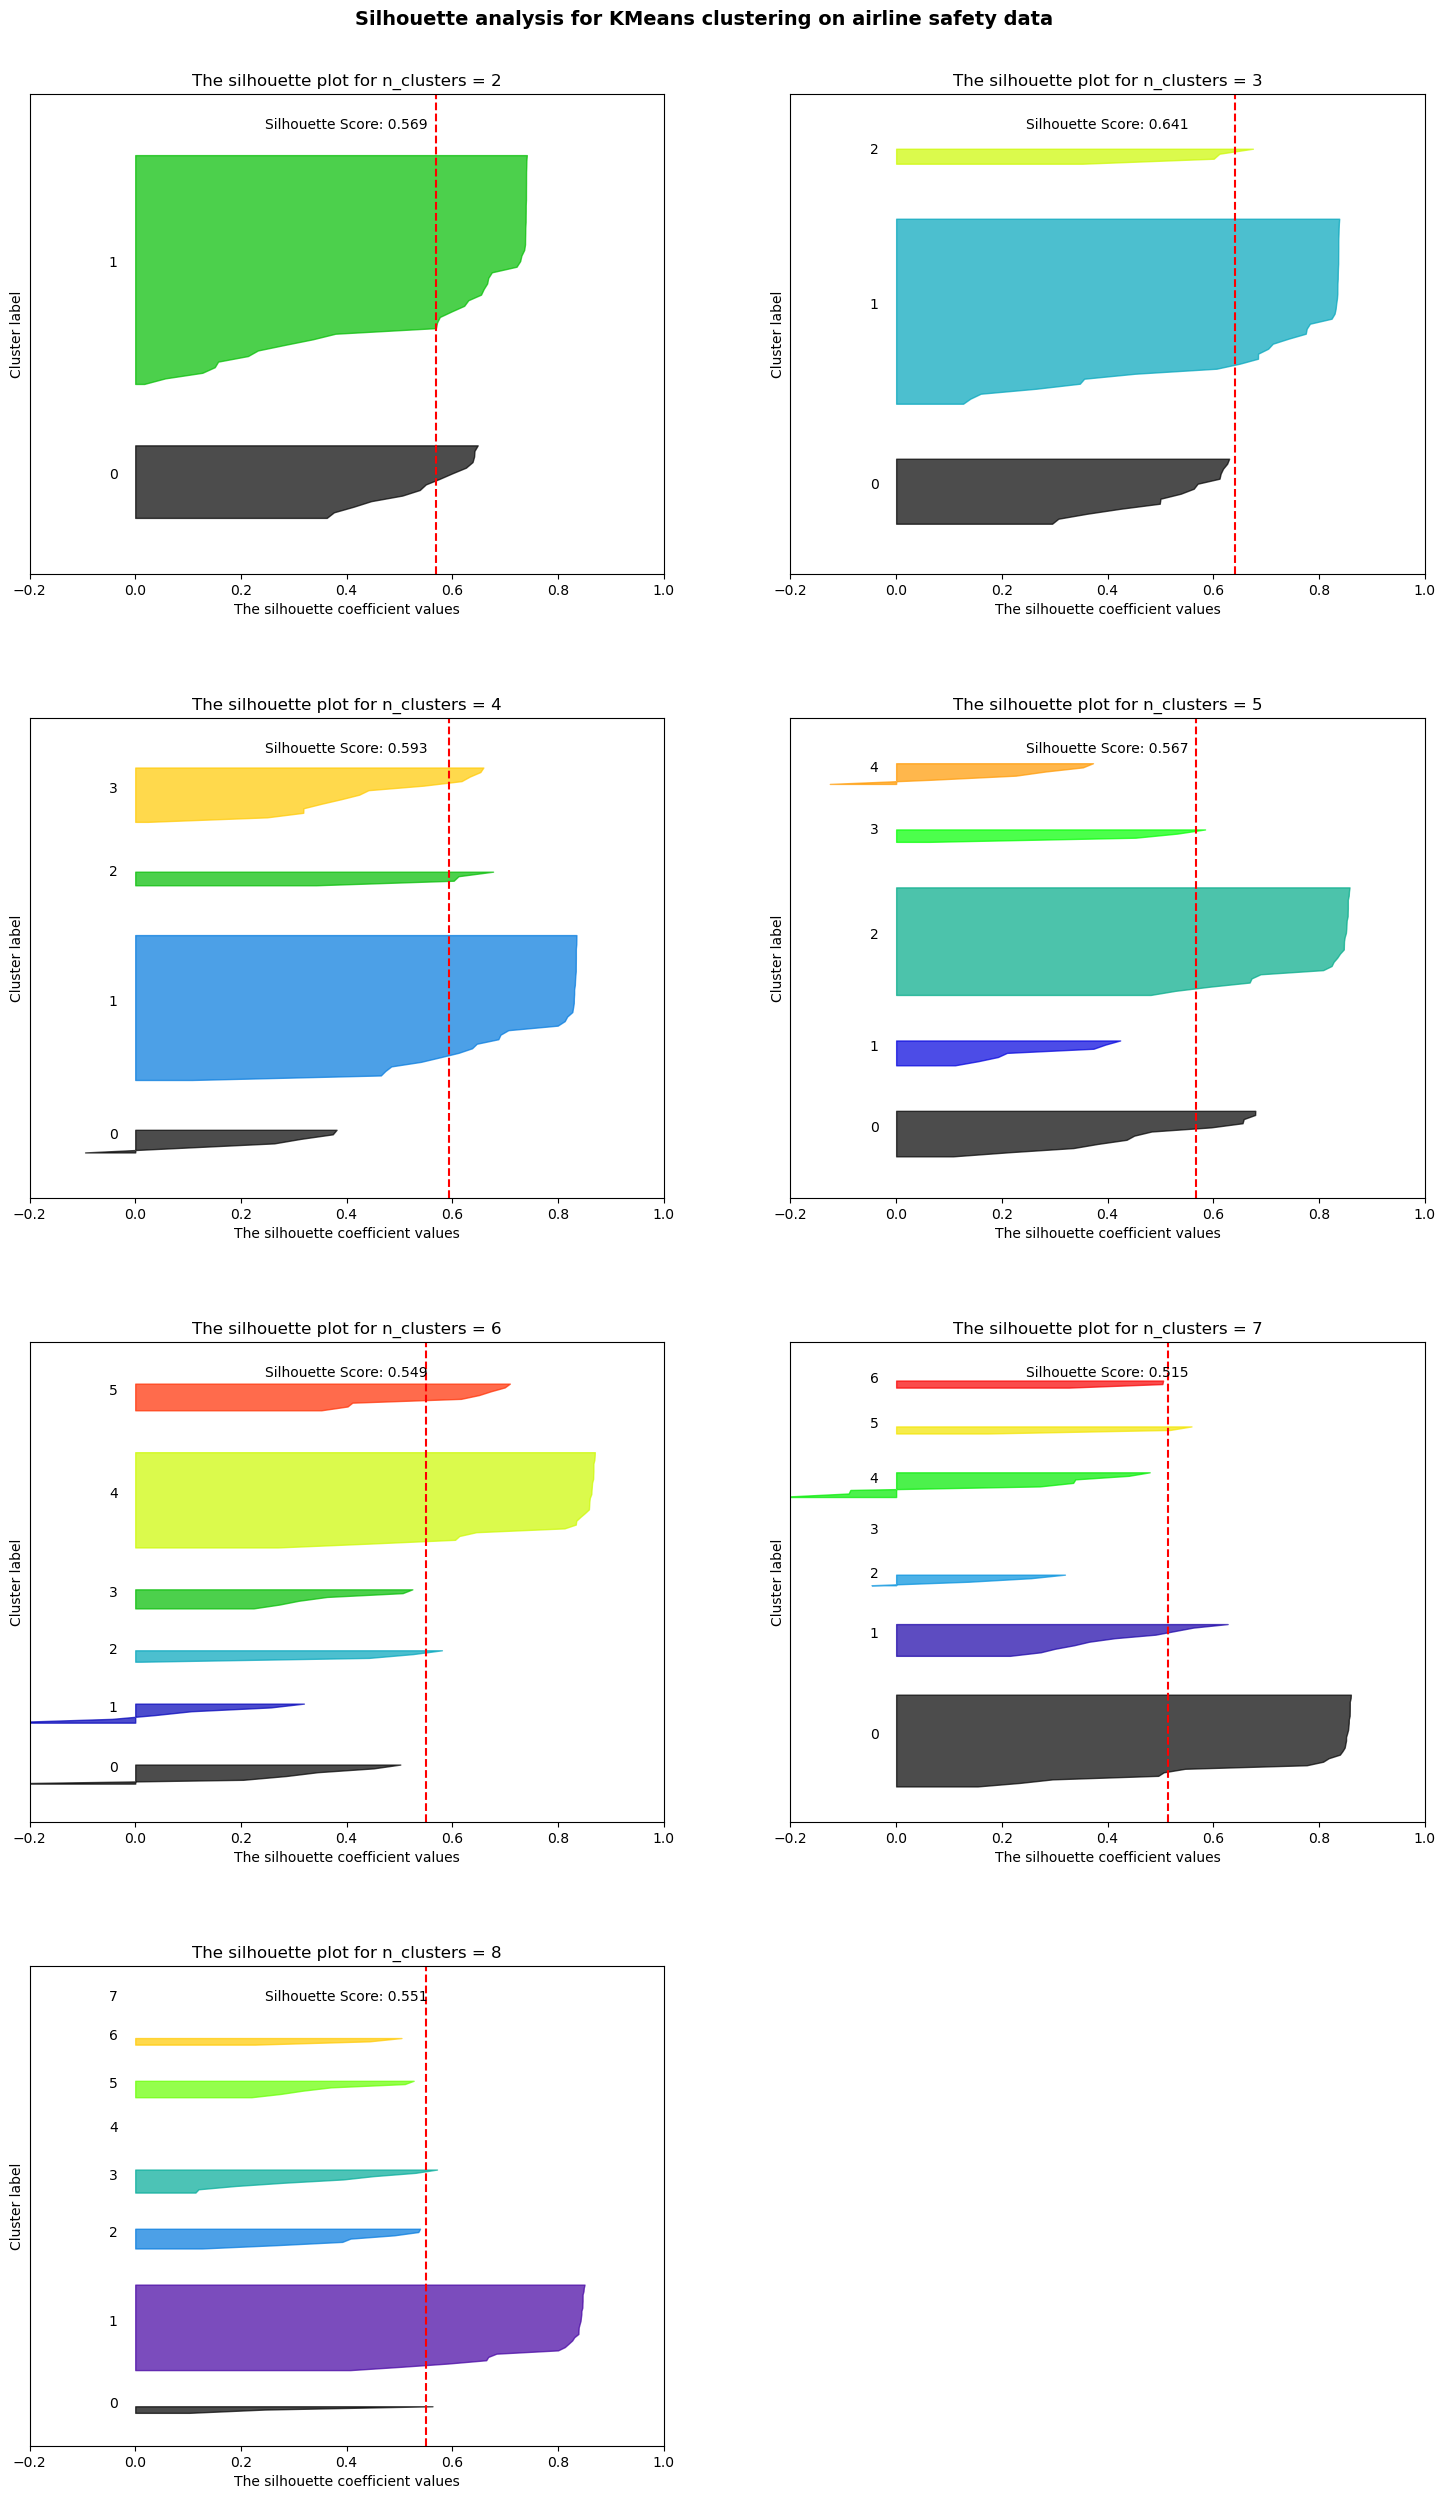

In [55]:
plot_knife(X_drop_km)

**Discussion of Task 1. Task 3 is also answered here**
> The dataset excluding the `avail_seat_km_per_week` feature yields the best outcome. The silhouette scores remain consistently high, with the maximum score occurring at K=3. This aligns with the elbow observed in the plot. Additionally, the silhouette analysis reveals a relatively even distribution of instances among the three clusters, with the silhouette scores crossing or coming close to each other. These findings collectively indicate a suitable choice for the K value.

>  The silhouette score is a measure of how well separated clusters are in a clustering analysis. It quantifies the cohesion and the separation. The silhouette score ranges from -1 to 1. A score of 1 indicates that a data point is well within a cluster, a score of 0 indicates that an instance is between clusters and a score of -1 indicates that an instance may have been assigned to the wrong cluster. The overall silhouette score for a clustering solution is the average silhouette score across all data points. A higher overall silhouette score indicates better defined and well separated clusters, while a lower score suggests overlapping or poorly separated clusters.

> The unscaled data tends to yield higher scores in clustering because scaling can sometimes distort the relative distances and distributions of data points. Without scaling, the clustering algorithm may capture the inherent patterns and structures more accurately, resulting in well separated clusters. However, in this case, the higher scores obtained with unscaled data can be attributed to the large difference in magnitude between the `avail_seat_km_per_week` feature and the rest of the features. Although it improves clustering, it comes at the expense of data interpretability and generalisation.

> On the other hand, scaling the data can potentially flatten or compress the data points, leading to overlapping or poorly separated clusters. This can result in lower silhouette scores, as observed in this case, with instances even having negative scores, indicating poor clustering performance.

> In terms of feature selection, removing the avail_seat_km_per_week feature led to significantly higher silhouette scores. Since the remaining features were already in the same units, there was no need for scaling. Therefore, this approach of removing the `avail_seat_km_per_week` feature was the most appropriate choice, as it improved clustering performance without the need for data scaling.

> I have chosen K=3 and will use this value in the rest of the question.

---
## Part 2 - Task 2
**Applying K-means clustering with K=3**

In [56]:
kmeans = KMeans(n_clusters=3, random_state=5508, n_init=10)
labels = kmeans.fit_predict(X_drop_km)

# Add the cluster labels to the dataset
airline_data['Cluster'] = labels

# Display the results
print(airline_data[['airline', 'Cluster']])


                       airline  Cluster
0                   Aer Lingus        1
1                    Aeroflot*        1
2        Aerolineas Argentinas        1
3                  Aeromexico*        1
4                   Air Canada        1
5                   Air France        2
6                   Air India*        0
7             Air New Zealand*        1
8             Alaska Airlines*        1
9                     Alitalia        1
10          All Nippon Airways        1
11                   American*        2
12           Austrian Airlines        1
13                     Avianca        0
14            British Airways*        1
15             Cathay Pacific*        1
16              China Airlines        0
17                      Condor        1
18                        COPA        1
19          Delta / Northwest*        0
20                    Egyptair        0
21                       El Al        1
22          Ethiopian Airlines        1
23                     Finnair        1


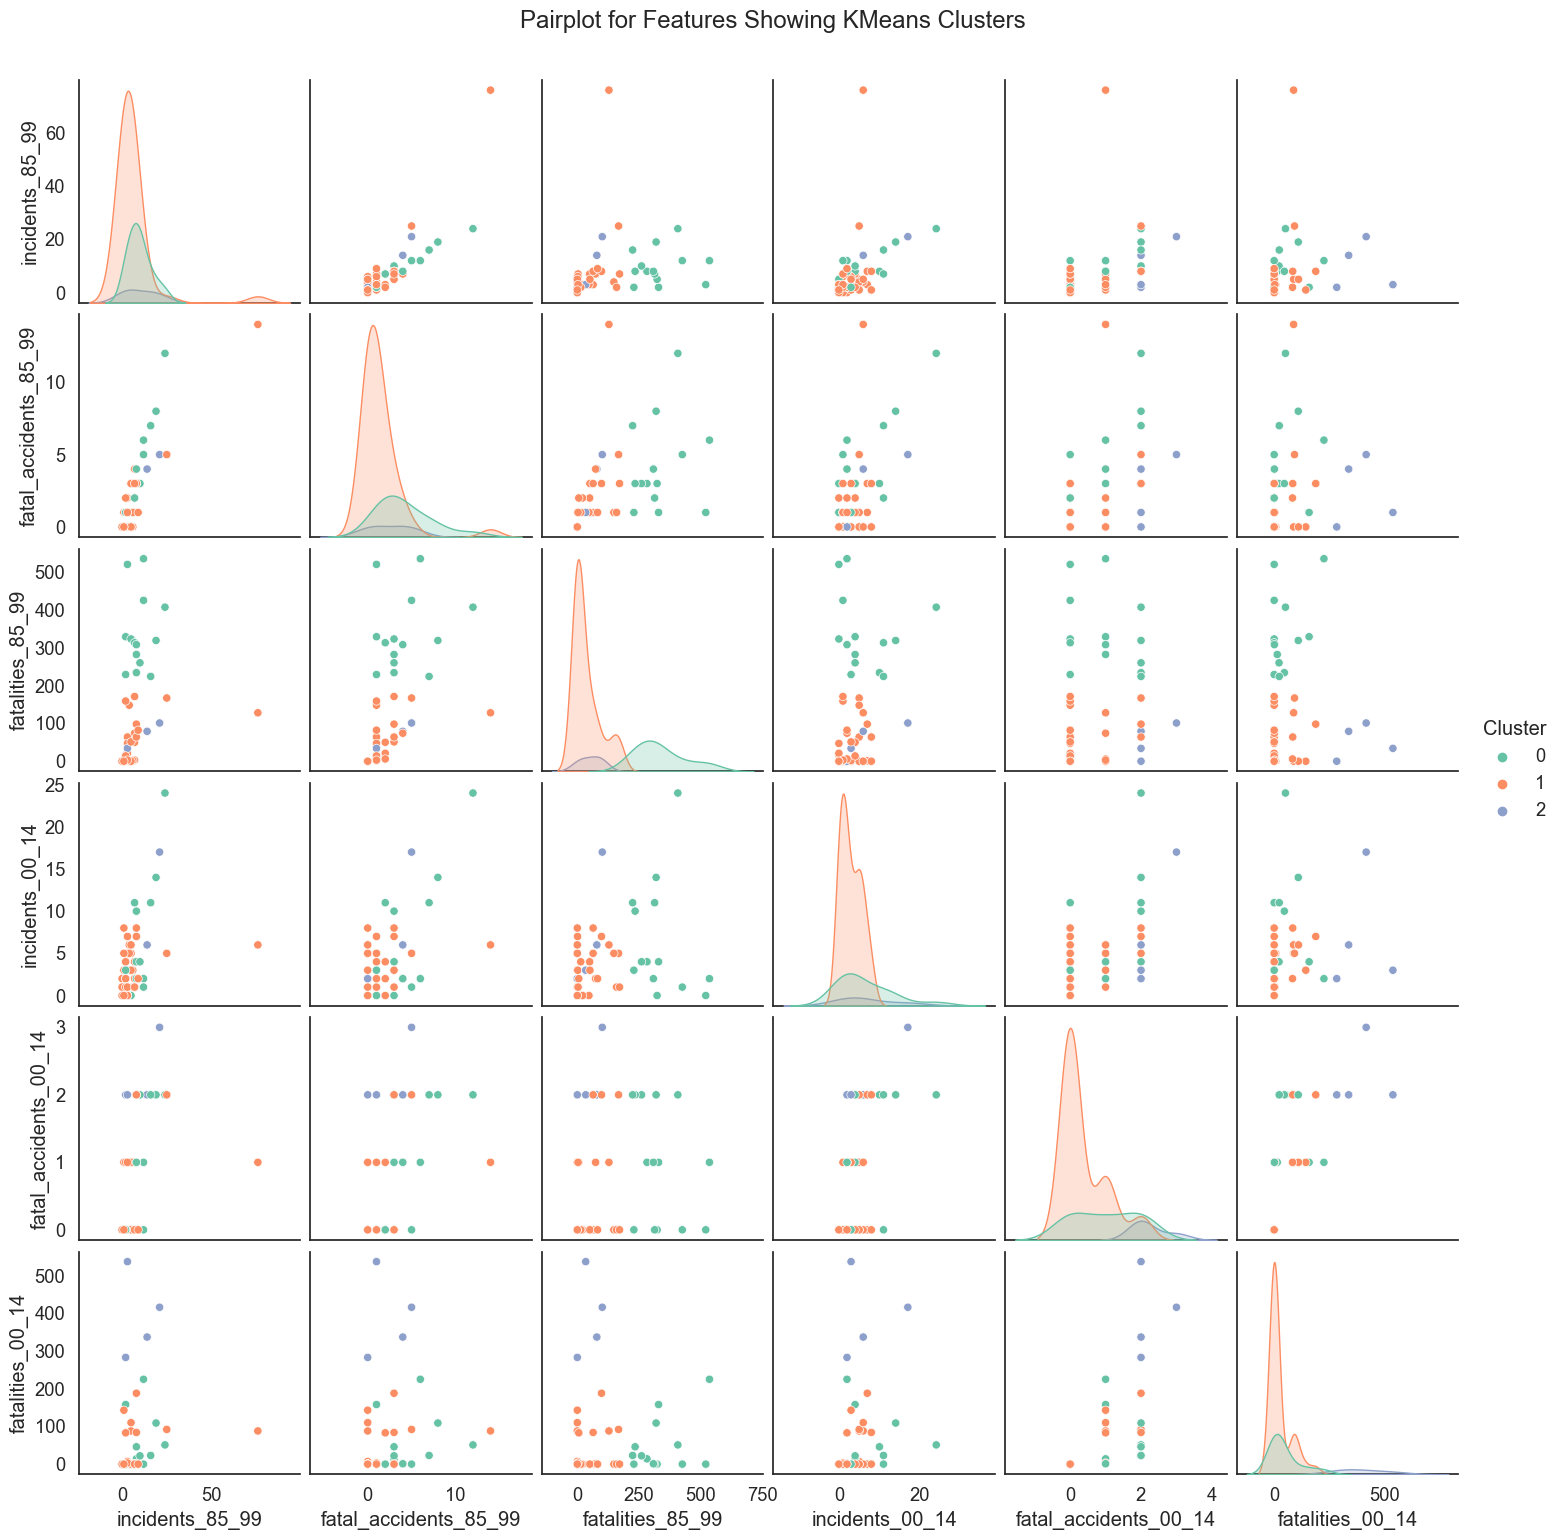

In [57]:
plot_sns(airline_data_dropped, X_drop_km, labels)

> The above plot shows the relationship between each of the features. The 3 colours represent the 3 clusters as a result of the K-means clustering.

> With many of the plots, there is a high level of overlap of the clusters. This suggests that the inherent patterns or structures in the data are not well defined or distinguishable using these features. The high level of overlap indicates that the clusters may not be adequately separated, making it challenging to draw clear boundaries between them.

> However, there are specific feature combinations, such as `fatalities_85_99` and `fatalities_00_14`, that exhibit notable separation between the clusters. This suggests that these particular features have a strong influence on the clustering process, and they contribute significantly to distinguishing between different groups within the data.

> We also see range of scales across the features. Specifically, the values related to the 2000 to 2014 period are considerably lower in magnitude compared to the older data, likely due to safer technology put in place. This discrepancy in scale can potentially affect the clustering results and interpretation of the patterns observed. 

> Including more instances in the dataset would greatly improve the reliability and comprehensiveness of the clustering analysis. Given the limited number of instances in each cluster and the presence of overlapping features, it becomes challenging to determine whether the observed patterns are meaningful or simply noise. However, there are certain plots that exhibit distinct separability between clusters, suggesting the presence of genuine patterns. More data would provide a more representative and reliable basis for identifying and interpreting underlying structures within the dataset.

> The clustering analysis is able to identify airlines with similar safety records.

## Part 2 - Task 3

**Answer in task 1 ("Discussion of Task 1. Also Task 3")**

## Part 2 - Task 4

**Performing a K-means cluster analysis, considering the value of K from Task 1, and: (a) the three variables from the years 1985-1999; (b) the three variables from the years 2000-2014**

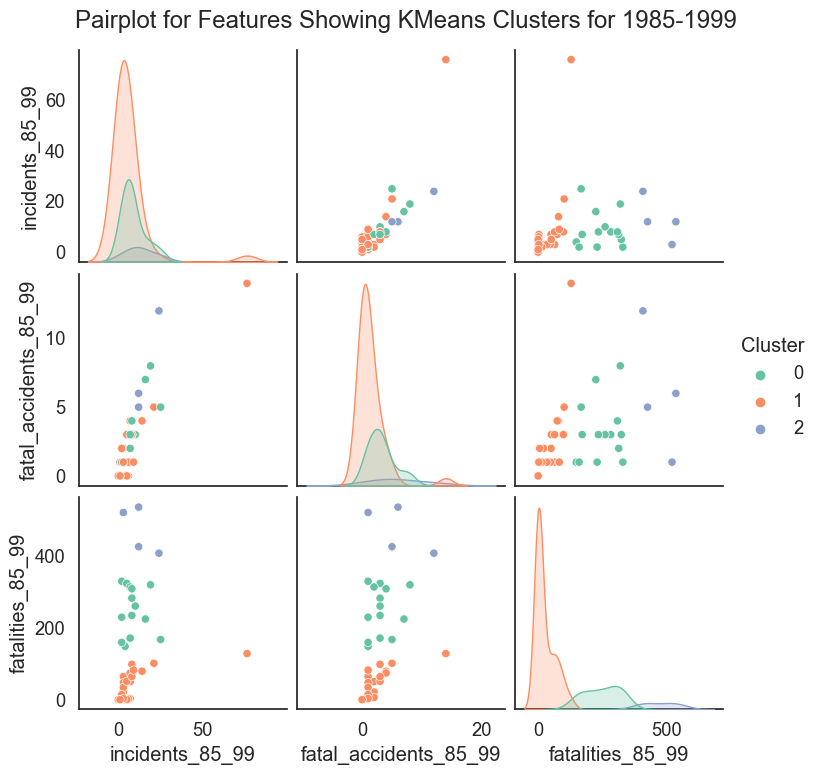

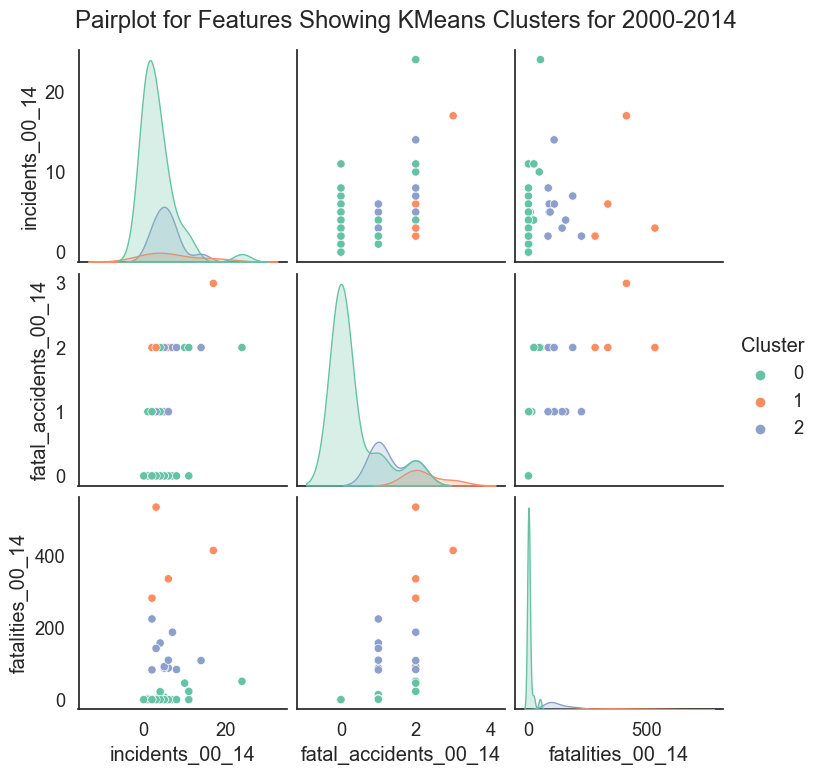

In [ ]:
# Extract the relevant columns for clustering (1985-1999)
X_85_99 = airline_data[['incidents_85_99', 'fatal_accidents_85_99', 'fatalities_85_99']]

# Extract the relevant columns for clustering (2000-2014)
X_00_14 = airline_data[['incidents_00_14', 'fatal_accidents_00_14', 'fatalities_00_14']]

# Set random state
random_state = 5508

# Perform K-means clustering (1985-1999)
kmeans_85_99 = KMeans(n_clusters=3, random_state=random_state, n_init=10)
kmeans_85_99.fit(X_85_99)
labels_85_99 = kmeans_85_99.labels_

# Perform K-means clustering (2000-2014)
kmeans_00_14 = KMeans(n_clusters=3, random_state=random_state, n_init=10)
kmeans_00_14.fit(X_00_14)
labels_00_14 = kmeans_00_14.labels_

plot_sns(X_85_99, X_85_99, labels_85_99, title='Pairplot for Features Showing KMeans Clusters for 1985-1999')
plot_sns(X_00_14, X_00_14, labels_00_14, title='Pairplot for Features Showing KMeans Clusters for 2000-2014')


> The above pairplots identify correlations between the airlines as well as differences between the older (1985-1999) and newer (2000-2014) data.

> The older data has significantly higher numbers of incidents, fatal accidents, and fatalities compared to the newer data. This difference can be attributed to the increased emphasis on safety measures and advancements in technology in more recent years, leading to a decline in such incidents.

> Furthermore, the clusters depicted in the pairplots have undergone changes compared to the previous plots. By comparing incident within the same time period, more direct comparisons can be made with more patterns between features. This enhanced cluster separation could be attributed to a better representation of the underlying patterns within the data or the presence of more discernible features that contribute to clustering.

## Part 2 - Task 5

**Considering feature ratios in K-means clustering**

In [ ]:
# Adding a small number to each of the instances to avoid divide-by-0 issues

#add_num = 0.00001
add_num = 1

# Create a copy of the DataFrame
airline_data_copy = airline_data.copy()

# Add a small number to the specified columns in the copied DataFrame
airline_data_copy['incidents_00_14'] = airline_data_copy['incidents_00_14'] + add_num
airline_data_copy['incidents_85_99'] = airline_data_copy['incidents_85_99'] + add_num
airline_data_copy['fatal_accidents_00_14'] = airline_data_copy['fatal_accidents_00_14'] + add_num
airline_data_copy['fatal_accidents_85_99'] = airline_data_copy['fatal_accidents_85_99'] + add_num
airline_data_copy['fatalities_00_14'] = airline_data_copy['fatalities_00_14'] + add_num
airline_data_copy['fatalities_85_99'] = airline_data_copy['fatalities_85_99'] + add_num

# Defining new features
incidents_ratio = airline_data_copy['incidents_00_14']/airline_data_copy['incidents_85_99']
fatal_accidents_ratio = airline_data_copy['fatal_accidents_00_14']/airline_data_copy['fatal_accidents_85_99']
fatalities_ratio = airline_data_copy['fatalities_00_14']/airline_data_copy['fatalities_85_99']

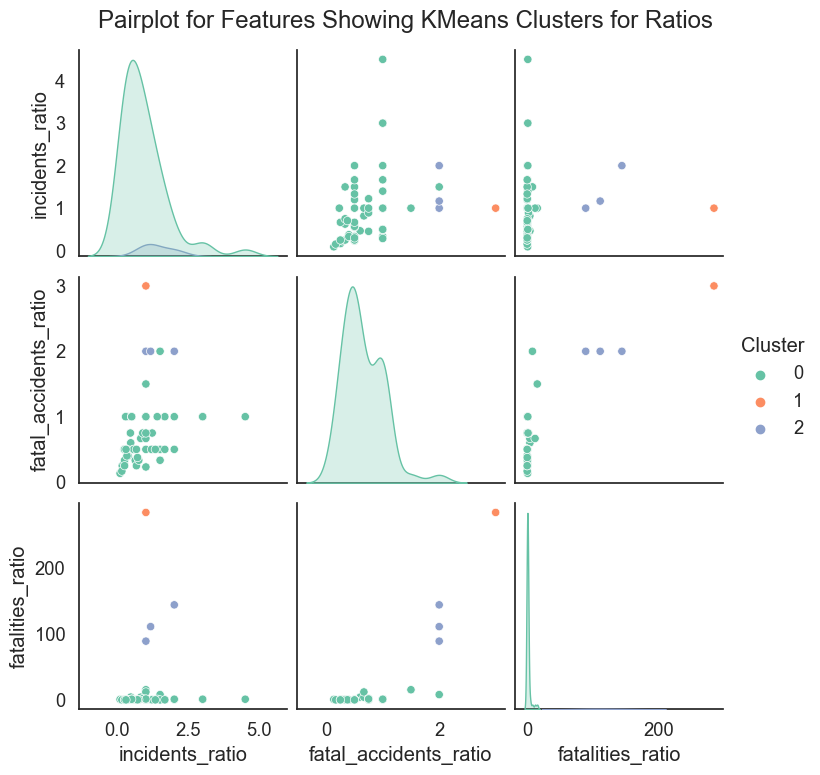

In [ ]:
# Combine the new features into a new DataFrame
new_features = pd.DataFrame({'incidents_ratio': incidents_ratio, 'fatal_accidents_ratio': fatal_accidents_ratio, 'fatalities_ratio': fatalities_ratio})

# Set random state
random_state = 5508

# Perform K-means clustering with the value of K from Task 1
k = 3  # Value of K from Task 1
kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
kmeans.fit(new_features)
labels = kmeans.labels_

plot_sns(new_features, new_features, labels, title='Pairplot for Features Showing KMeans Clusters for Ratios')



> The above pairplot showcases the correlations between the ratios of older data to newer data and highlights the resulting clusters. It is important to note that the dataset contains only 55 data points, which leads to relatively low counts within some of the clusters. To avoid issues with NaN and infinity, we added a value of 1 to each of the features.

> One notable observation is the high level of separation among the data points, indicating that these new features are effective in the k-means clustering process. Interestingly, there is a single instance in the orange cluster. It is possible that this data point could be an outlier, the limited number of instances makes it challenging to determine whether this is indeed an outlier or if a cluster exists in this particular location. More supporting data would be necessary to confirm the presence of a distinct cluster.

> > The pairplot reveals a significant proportion of smaller values, suggesting that the more recent data generally exhibits lower rates of safety issues compared to the older data. This trend aligns with the industry's increased focus on safety measures and advancements over time.

> Moreover, the pairplot demonstrates clear and distinct clusters, with the largest cluster exhibiting the highest level of uniformity. This indicates a higher degree of similarity among the data points within this cluster, highlighting the presence of a cohesive subgroup within the dataset.

> These features would be effective in determining similarity between airlines in terms of safety report. We already see clear clusters here with a small number of data points. 

In [ ]:
# Add the cluster labels to the original dataset
new_features['cluster_labels'] = labels
new_features['airline'] = airline_data['airline']

# Print the cluster analysis results
cluster_analysis = new_features[['airline', 'incidents_ratio', 'fatal_accidents_ratio', 'fatalities_ratio', 'cluster_labels']]
print(cluster_analysis)

                       airline  incidents_ratio  fatal_accidents_ratio  \
0                   Aer Lingus         0.333333               1.000000   
1                    Aeroflot*         0.090909               0.133333   
2        Aerolineas Argentinas         0.285714               1.000000   
3                  Aeromexico*         1.500000               0.500000   
4                   Air Canada         1.000000               1.000000   
5                   Air France         0.466667               0.600000   
6                   Air India*         1.666667               1.000000   
7             Air New Zealand*         1.500000               2.000000   
8             Alaska Airlines*         1.000000               2.000000   
9                     Alitalia         0.625000               0.333333   
10          All Nippon Airways         2.000000               0.500000   
11                   American*         0.818182               0.666667   
12           Austrian Airlines        

# Part 3 - A clustering analysis on US arrests data

**Defining the functions to be used in this question**

In [ ]:
def plot_means(data, set_max_y=True):
    
    # Group the data by cluster and calculate the mean values
    cluster_means = data.groupby('Cluster')['Murder', 'Rape', 'Assault', 'UrbanPop'].mean()

    # Get the maximum mean value across all clusters
    max_mean = cluster_means.max().max()

    # Plotting three bar plots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, ax in enumerate(axes):
        cluster_data = cluster_means.iloc[i]
        ax.bar(cluster_data.index, cluster_data.values)
        ax.set_title(f'Cluster {i+1}')
        ax.set_ylabel('Mean Value')
        ax.set_xlabel('Variable')

        if set_max_y==True:
            ax.set_ylim([0, max_mean])  # Set a common y-axis range

        if set_max_y==False:
            ax.set_ylim([-0.8, 1.5])  # Set a common y-axis range

    plt.tight_layout()
    plt.show()

## Part 3 - Task 1

**Performing hierarchical clustering with complete linkage and Euclidean distance**

In [ ]:
data_US = pd.read_csv('USArrests.csv')
X_US = data_US.iloc[:, 1:].values  # Selecting columns 1 to 4 (Murder, Assault, Rape, UrbanPop)

# Calculate the linkage matrix using complete linkage and Euclidean distance
Z = linkage(X_US, method='complete', metric='euclidean')

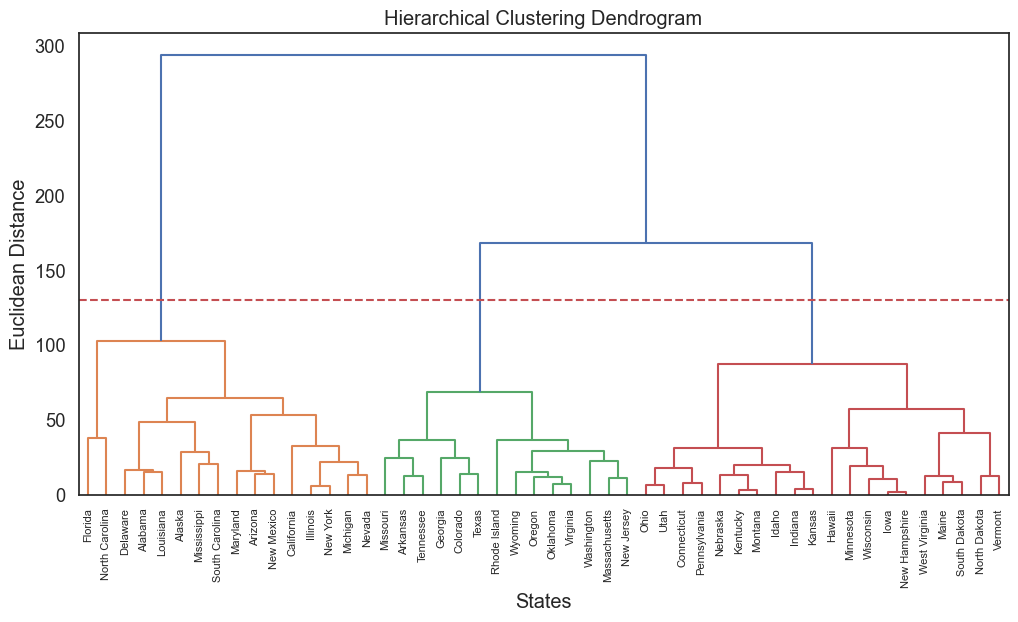

In [ ]:
# Plotting the dendrogram

thresh = 130

plt.figure(figsize=(12, 6))
dendrogram(Z, labels=data_US.iloc[:, 0].values, leaf_rotation=90, color_threshold=thresh)
plt.xlabel('States')
plt.ylabel('Euclidean Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.axhline(y=thresh, color='r', linestyle='--')  # Add the horizontal line at height 130
plt.show()

In [ ]:
# Assign cluster labels based on the chosen cutoff
clusters = fcluster(Z, t=thresh, criterion='distance')

# Add the cluster labels to the dataset
data_US['Cluster'] = clusters

# Print the clusters
#print(data_US[['State', 'Cluster']])

**Displaying the states that belong to each cluster**

In [ ]:
display_cluster_lists(Z, data_US, thresh=130)

Cluster 1: ['Alabama', 'Alaska', 'Arizona', 'California', 'Delaware', 'Florida', 'Illinois', 'Louisiana', 'Maryland', 'Michigan', 'Mississippi', 'Nevada', 'New Mexico', 'New York', 'North Carolina', 'South Carolina']
Cluster 2: ['Arkansas', 'Colorado', 'Georgia', 'Massachusetts', 'Missouri', 'New Jersey', 'Oklahoma', 'Oregon', 'Rhode Island', 'Tennessee', 'Texas', 'Virginia', 'Washington', 'Wyoming']
Cluster 3: ['Connecticut', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Minnesota', 'Montana', 'Nebraska', 'New Hampshire', 'North Dakota', 'Ohio', 'Pennsylvania', 'South Dakota', 'Utah', 'Vermont', 'West Virginia', 'Wisconsin']


**Plotting the mean variables of each cluster**

/var/folders/7p/23vn8v_n2ld2zplx_01w7kf80000gn/T/ipykernel_42003/1820166060.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cluster_means = data.groupby('Cluster')['Murder', 'Rape', 'Assault', 'UrbanPop'].mean()


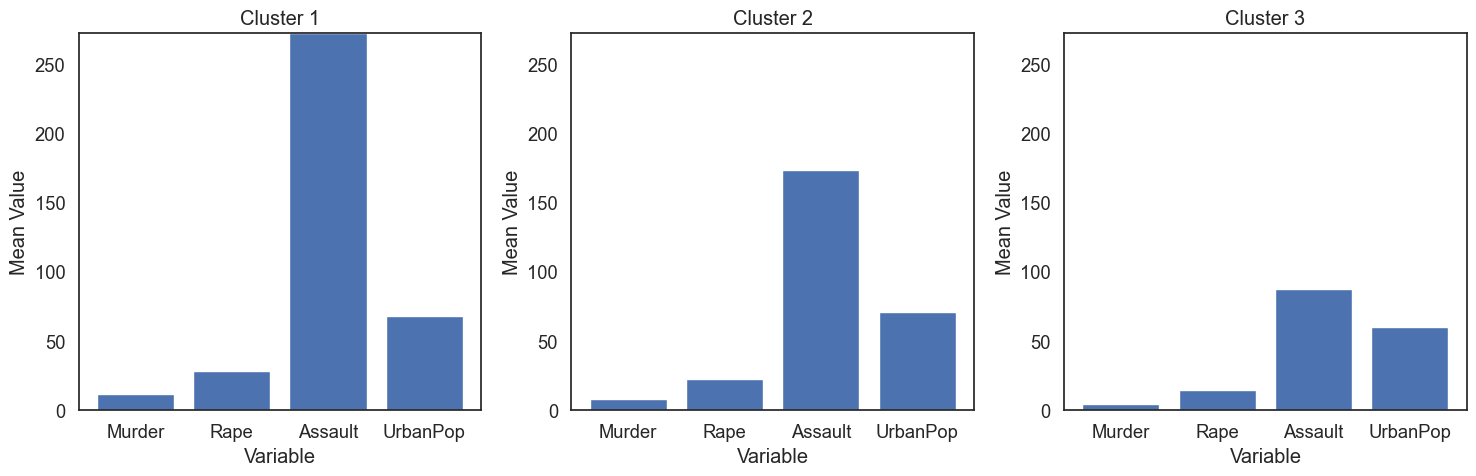

In [ ]:
plot_means(data_US)

> The states belonging to each cluster are displayed in the dendrogram and the above list. In the dendrogram, we observe that clusters merge at a similar height, indicating a comparable level of dissimilarity between the merged clusters. The height of each vertical line represents the distance between the merged clusters, with longer lines indicating greater dissimilarity.

> In this dendrogram, the vertical lines within the clusters remain relatively short, suggesting higher similarity within each cluster. In contrast, the lines are longer at the cutoff point, indicating greater dissimilarity between the three clusters.


> Additionally, examining the mean values of the crimes for each cluster reveals a distinct pattern. Cluster 1 exhibits the highest average rates for each crime, followed by cluster 2 and then cluster 3. This pattern suggests that the centroids of these clusters are likely influenced by these mean values, with cluster 1 representing states with relatively higher crime rates and cluster 3 representing states with relatively lower crime rates

> The mean urban population amongst the 3 clusters remains relatively the same. This indicates a consistent distribution of urban population across the states within each cluster. This suggests that the clustering algorithm primarily considered other variables (such as Murder, Rape, and Assault rates) rather than the urban population percentage when forming the clusters.

> With additional data, it would be possible to explore and compare various features that could further quantify the clustering of states. Some potential features to consider could include the cost of living, wages, age distribution, population density, and other relevant socio-economic factors. This would enable a deeper exploration of the relationships between crime rates, urban population, and these additional socio-economic features.

## Part 3 - Task 2

**Reapting task 1 after scaling the data**

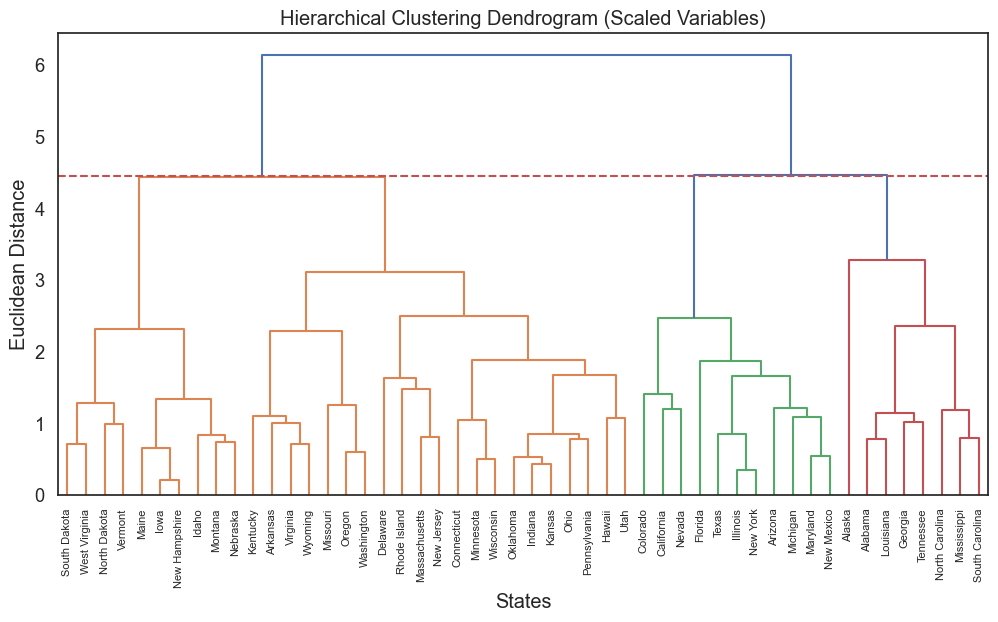

In [ ]:
# Scale the variables to have zero mean and unit standard deviation
scaler = StandardScaler()
X_US_scaled = scaler.fit_transform(X_US)

# Calculate the linkage matrix using complete linkage and Euclidean distance
Z_scaled = linkage(X_US_scaled, method='complete', metric='euclidean')

plt.figure(figsize=(12, 6))
dendrogram(Z_scaled, labels=data_US.iloc[:, 0].values, leaf_rotation=90, color_threshold=4.45)
plt.xlabel('States')
plt.ylabel('Euclidean Distance')
plt.title('Hierarchical Clustering Dendrogram (Scaled Variables)')
plt.axhline(y=4.45, color='r', linestyle='--')  # Add the horizontal line at height 130
plt.show()

**Displaying the states that belong to each cluster**

In [ ]:
X_US_scaled_pd = pd.DataFrame(X_US_scaled, columns=['Murder', 'Assault', 'UrbanPop', 'Rape'])

# Assign cluster labels based on the chosen cutoff
clusters_scaled = fcluster(Z_scaled, t=4.45, criterion='distance')

# Add the cluster labels to the dataset
X_US_scaled_pd['Cluster'] = clusters_scaled
X_US_scaled_pd['State']=data_US['State']

display_cluster_lists(Z_scaled, X_US_scaled_pd, thresh=4.45)


Cluster 1: ['Arkansas', 'Connecticut', 'Delaware', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Massachusetts', 'Minnesota', 'Missouri', 'Montana', 'Nebraska', 'New Hampshire', 'New Jersey', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Dakota', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
Cluster 2: ['Arizona', 'California', 'Colorado', 'Florida', 'Illinois', 'Maryland', 'Michigan', 'Nevada', 'New Mexico', 'New York', 'Texas']
Cluster 3: ['Alabama', 'Alaska', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee']


**Plotting the mean variables of each cluster**

/var/folders/7p/23vn8v_n2ld2zplx_01w7kf80000gn/T/ipykernel_42003/1820166060.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cluster_means = data.groupby('Cluster')['Murder', 'Rape', 'Assault', 'UrbanPop'].mean()


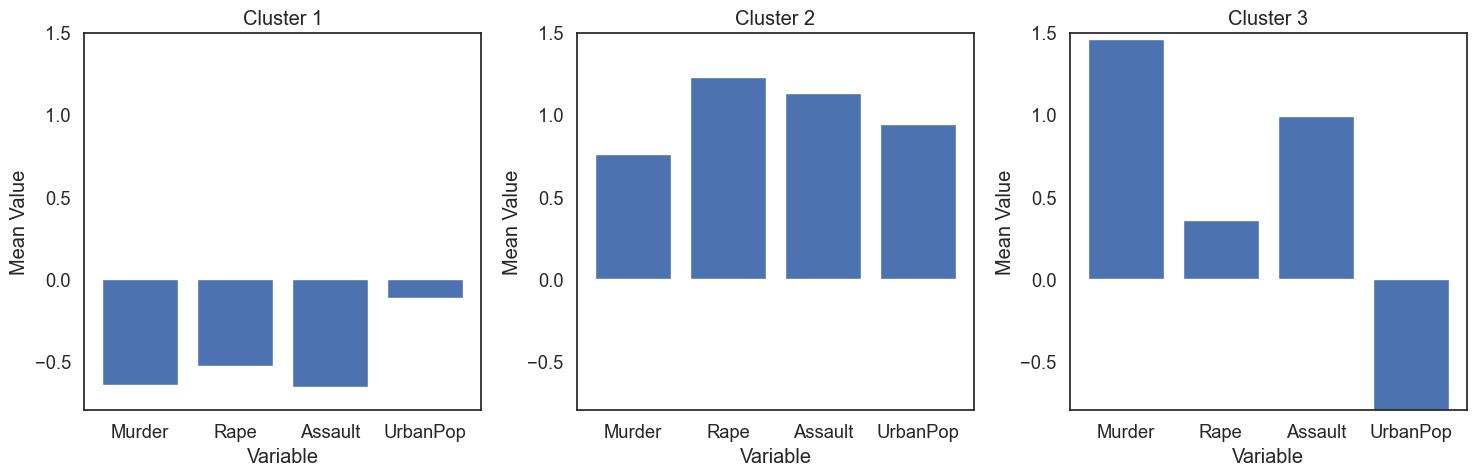

In [ ]:
plot_means(X_US_scaled_pd, set_max_y=False)

> Scaling the variables has the effect of standardising the data, ensuring that each variable has the same scale and removing any biases introduced by differences in the original ranges. For this data, `Murder`, `Assault` and `Rape` were measured per 100,000. Whereas the `UrbanPop` was a percentage. It is therefore necessary to scale the data to allow for better data implementation. Scaling eliminates the potential dominance of variables with larger magnitudes, which in this case is `Murder`, `Assault` and `Rape`.

> Looking at the dendrogram, we can see that the vertical lines are longer. This indicates a larger dissimilarity between clusters at different levels. This can be attributed to the scaling process, which equalises the importance of each variable in the clustering analysis. As a result, variables with larger magnitudes, such as `Assault` or `Murder`, may contribute more to the dissimilarity between clusters compared to variables with smaller magnitudes, such as `UrbanPop`.

> It is also seen that one cluster contains more states than the other two. Looking at the means of the variables, we see that this cluster has notably lower crime rates than the other clusters. It seems that many states fall into this 'low crime rate' category. Although, this is a comparison to other state. It is equally likely that there is a smaller subset of states which has far higher crime rates.

> Looking at the averages of the means, we observe different characteristics in the scaled data compared to the unscaled data. Firstly, in cluster 1, we notice a low rate of crime. Interestingly, there appears to be a correlation between crime and urban population. States with a moderately sized urban population tend to have lower crime rates in this cluster. On the other hand, cluster 2 comprises states with a significantly higher urban population, and correspondingly, a higher rate of crime. In cluster 3, we observe states with a smaller urban population, yet a relatively high rate of crime.





## Part 3 - Task 3

**Performing a PCA on the data and using it to perform hierarchical clustering**

In [ ]:
# Perform PCA
pca = PCA(n_components=2)
PC_scores = pca.fit_transform(X_US_scaled)

# Calculate the linkage matrix using complete linkage and Euclidean distance on the first two principal components
Z_PCA = linkage(PC_scores, method='complete', metric='euclidean')

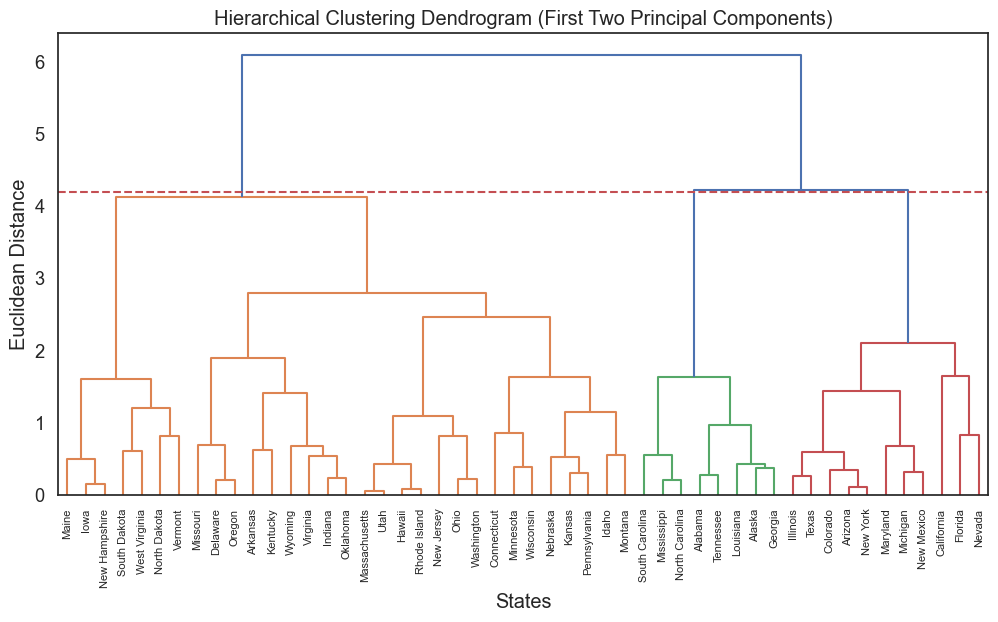

In [ ]:
# Cut the dendrogram at a height that results in three distinct clusters
plt.figure(figsize=(12, 6))
dendrogram(Z_PCA, labels=data_US.iloc[:, 0].values, leaf_rotation=90, color_threshold=4.2)
plt.xlabel('States')
plt.ylabel('Euclidean Distance')
plt.title('Hierarchical Clustering Dendrogram (First Two Principal Components)')
plt.axhline(y=4.2, color='r', linestyle='--')  # Add the horizontal line at height 130
plt.show()

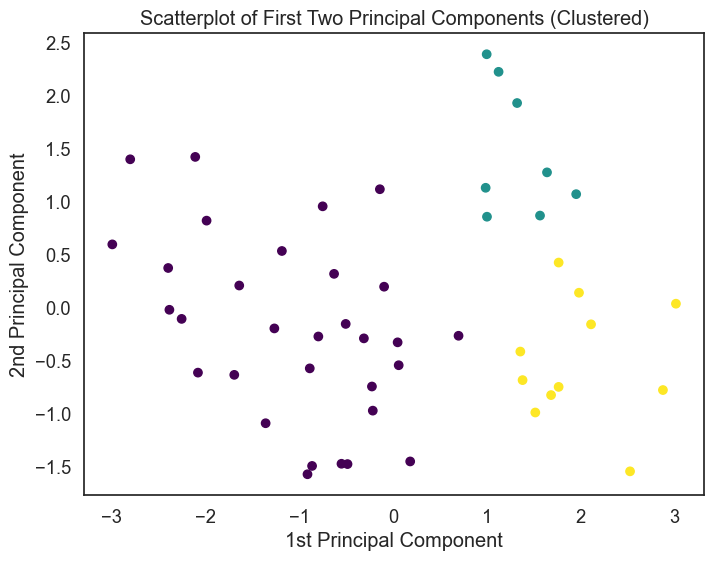

In [ ]:
# Assign cluster labels based on the chosen cutoff
clusters_PCA = fcluster(Z_PCA, t=4.2, criterion='distance')

# Add the cluster labels to the dataset
# data_US['Cluster'] = clusters

# Plot the scatterplot of the first two principal components with different colors for each cluster
plt.figure(figsize=(8, 6))
plt.scatter(PC_scores[:, 0], PC_scores[:, 1], c=clusters_PCA, cmap='viridis')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.title('Scatterplot of First Two Principal Components (Clustered)')
plt.show()

> In this task, PCA was applied to the data to obtain the first two principal components. These components were then used to create a dendrogram through hierarchical clustering with complete linkage and Euclidean distance. When comparing this to the dendrogram in task 2, we find that there are many similarities. The height at which the dendrogram needs to be cut to obtain three distinct clusters is relatively consistent, with 4.2 in this PCA-based clustering and 4.45 in the previous clustering performed on the scaled data.

> Again, the dendrogram reveals an imbalanced cluster distribution, where one cluster appears significantly larger than the other two, which is consistent with the previous analysis. This pattern is also reflected in the scatterplot of the first two principal components, where one cluster is noticeably larger than the other two.

> The clear separation observed between the clusters in the PCA scatterplot shows that the clusters are well defined. THis indicates that the PCA has captured meaningful patterns in the data.


## Part 3 - Task 4

**Repeating the analysis of Task 3 using the K-means clustering (with K=3)**

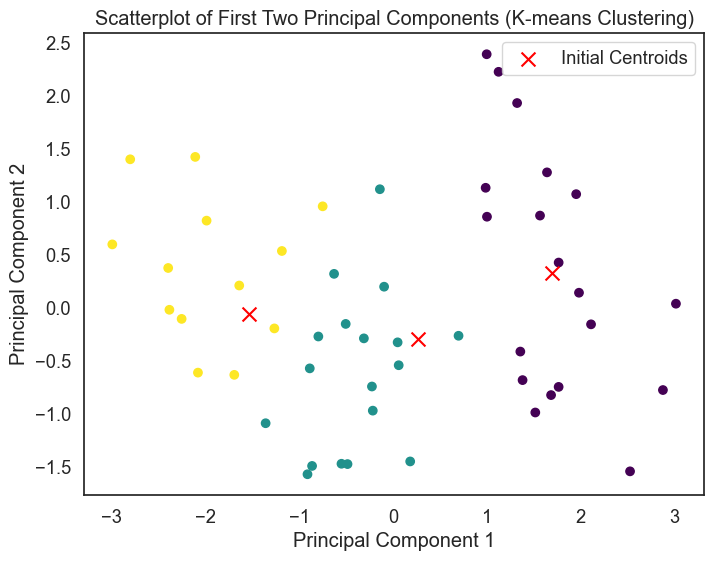

In [ ]:
# Compute group means from hierarchical clustering
group_means = pd.DataFrame(PC_scores).groupby(clusters).mean()

# Use group means as initial centroids for K-means clustering
kmeans_US = KMeans(n_clusters=3, init=group_means.values, n_init=1, random_state=5508)
kmeans_US.fit(PC_scores)

# Get the cluster labels from K-means clustering
kmeans_clusters = kmeans_US.labels_

# Plot the scatterplot of the first two principal components with different colors for each K-means cluster
plt.figure(figsize=(8, 6))
plt.scatter(PC_scores[:, 0], PC_scores[:, 1], c=kmeans_clusters, cmap='viridis')
plt.scatter(group_means.iloc[:, 0], group_means.iloc[:, 1], c='red', marker='x', s=100, label='Initial Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatterplot of First Two Principal Components (K-means Clustering)')
plt.legend()
plt.show()

> The results obtained here are identical to those in task 3. However, this method is particularly advantageous when dealing with a larger volume of data. By initialising the centroids to the means of the PCA-transformed data, we enable the model to refine the clustering process more efficiently, avoiding unnecessary attempts to determine the precise location of each cluster. This approach allows us to pre-define the clusters and exercise control over the clustering process, enhancing the overall effectiveness and interpretability of the results.




